# SmartBite — AI-Driven Cafeteria Demand Forecasting

## Introduction and Project Motivation

College cafeterias often rely on manual estimation to plan daily food production. This leads to two major issues:
- Excess food waste from over-preparation  
- Shortages and long queues from under-preparation  

SmartBite solves this by using data-driven forecasting and machine learning to accurately predict demand and uncover student consumption patterns.  
The project builds a complete end-to-end pipeline including data cleaning, feature engineering, forecasting, association rule mining, clustering, explainability, and final packaging.

## Problem Statement

**Predict daily food demand in college cafeterias to reduce shortages and minimize food waste.**

## Project Objectives and Achievements

| Objective | How This Notebook Achieves It |
|----------|--------------------------------|
| **Predict Daily Food Demand (per dish & per meal)** | Achieved using a tuned **XGBoost model** with engineered time-series features, lag values, rolling averages, and event/vacation flags. |
| **Model Event-Driven & Seasonal Demand Patterns** | Achieved using **Prophet**, which provides trend, weekly seasonality, yearly seasonality, and special-day effects. |
| **Analyze Student Preferences & Suggest Menu Adjustments** | Achieved using **Apriori association rules** to find dish pairings and **K-Means clustering** to identify distinct demand day-types. |
| **Provide Explainability for Decision-Making** | Achieved using **SHAP**, showing the most influential features affecting demand predictions. |
| **Deliver Actionable Insights & Final Project Package** | Achieved by exporting all models, reports, visualizations, and recommendations into a unified ZIP file. |


## **Cell 1 — Environment Setup & Project Initialization**

This cell prepares the working environment for the SmartBite project by:

- **Creating a structured project folder setup** (`data`, `models`, `reports`, `figures`, etc.) inside `/content/SmartBite`.
- **Ensuring reproducibility** by setting a global random seed (`SEED = 42`) for Python, NumPy, and hashing.
- **Optionally mounting Google Drive** to enable persistent storage in `MyDrive/SmartBite_Project`.
- **Printing environment details** such as Python version and platform info.

**Key Outcome:**  
All project folders were created successfully, Google Drive was mounted, and the environment is ready for further setup.


In [1]:
# ================================================================
# Cell 1 — Colab environment setup & project folders
# ================================================================
import os
import sys
import platform
from pathlib import Path
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# ---------- Configuration & Globals ----------
# If you want persistence, set MOUNT_DRIVE = True and follow the printed instructions.
MOUNT_DRIVE = True   # set to True if you want to mount Google Drive
DRIVE_TARGET_DIR = "SmartBite_Project"   # folder name inside MyDrive to store project files (if mounting)

# Local working directory inside Colab VM (fast ephemeral storage)
WORKDIR = Path("/content/SmartBite")

# Subfolders for good project hygiene
SUBFOLDERS = {
    "data": WORKDIR / "data",
    "notebooks": WORKDIR / "notebooks",
    "models": WORKDIR / "models",
    "reports": WORKDIR / "reports",
    "figures": WORKDIR / "figures",
    "logs": WORKDIR / "logs"
}

# Define main global paths for use in other cells
DATA_PATH = SUBFOLDERS["data"]
MODELS_PATH = SUBFOLDERS["models"]
FIGURES_PATH = SUBFOLDERS["figures"]

# ---------- Reproducibility ----------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ---------- Utility: mount drive if requested ----------
def try_mount_drive():
    try:
        from google.colab import drive
    except Exception:
        print("Drive mount not available in this environment (not Colab). Skipping mount.")
        return None

    print("Mounting Google Drive... (you will be prompted to authenticate)")
    drive.mount('/content/drive', force_remount=False)
    drive_root = Path("/content/drive/MyDrive")
    target = drive_root / DRIVE_TARGET_DIR
    target.mkdir(parents=True, exist_ok=True)
    print(f"Project folder on Drive: {target}")
    return target

# ---------- Create local folders ----------
def create_project_structure():
    WORKDIR.mkdir(parents=True, exist_ok=True)
    for k, p in SUBFOLDERS.items():
        p.mkdir(parents=True, exist_ok=True)
    print("\nCreated local project folders:")
    for k, p in SUBFOLDERS.items():
        print(f"  - {k:10s}: {p}")

# ---------- Print environment info ----------
def print_env_info():
    print("\n--- Environment Info ---")
    print(f"Python: {sys.version.splitlines()[0]}")
    print(f"Platform: {platform.platform()}")
    print(f"Random seed set to: {SEED}")

# ---------- Run setup ----------
print(f"Initializing SmartBite Project...")
if MOUNT_DRIVE:
    drive_path = try_mount_drive()
    if drive_path:
        # User can decide to sync data here later
        pass

create_project_structure()
print_env_info()
print("\nProceed to Cell 2 for library installation.")

Initializing SmartBite Project...
Mounting Google Drive... (you will be prompted to authenticate)
Mounted at /content/drive
Project folder on Drive: /content/drive/MyDrive/SmartBite_Project

Created local project folders:
  - data      : /content/SmartBite/data
  - notebooks : /content/SmartBite/notebooks
  - models    : /content/SmartBite/models
  - reports   : /content/SmartBite/reports
  - figures   : /content/SmartBite/figures
  - logs      : /content/SmartBite/logs

--- Environment Info ---
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Random seed set to: 42

Proceed to Cell 2 for library installation.


## Cell 2 — Library Installation and Global Settings

This cell installs all required Python libraries and prepares the environment for the full SmartBite workflow.

### What this cell does
- Installs all core and advanced packages needed for the project, including Pandas, NumPy, Scikit-learn, XGBoost, SHAP, Prophet, and MLxtend.
- Imports all modeling, preprocessing, visualization, and explainability modules used in later cells.
- Applies global visualization and display settings to ensure clean and consistent plots.
- Prints key library versions for reproducibility and documentation.

### Why it matters
- Ensures all upcoming cells (EDA, feature engineering, modeling, tuning, forecasting, SHAP analysis, association rules, clustering) run smoothly.
- Standardizes the environment for consistent results across executions.


In [2]:
# ================================================================
# Cell 2 — Install & Import Required Libraries
# ================================================================

# --- Step 1: Install missing packages ---
print("Installing required packages...")
!pip install -q cmdstanpy  # Install the backend FIRST
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost shap joblib prophet mlxtend
print("Installation complete.")

# --- Step 2: Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports (Modeling & Preprocessing)
from sklearn.model_selection import TimeSeriesSplit  # CRITICAL for time-series integrity
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Model Imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb  # for version info

# Advanced & Explainability Imports
import shap
import joblib

# Milestone 3 Specific Imports
try:
    from prophet import Prophet  # Advanced forecasting model
except ImportError:
    print("Warning: Prophet import failed. It may require specific setup (e.g., cmdstanpy).")

from mlxtend.frequent_patterns import apriori, association_rules  # For Menu Preference Analysis

# Utility
import warnings
import os

# --- Step 3: Global Settings ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Pandas display options for clarity
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Matplotlib & Seaborn visualization style
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# --- Step 4: Quick confirmation ---
print("\nLibraries successfully imported and settings applied!")

# Printing library versions for documentation
print("--- Library Versions ---")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"SHAP: {shap.__version__}")

print("\nProceed to Cell 3 to load the dataset.")


Installing required packages...
Installation complete.

Libraries successfully imported and settings applied!
--- Library Versions ---
Pandas: 2.2.2
NumPy: 2.0.2
XGBoost: 3.1.2
SHAP: 0.50.0

Proceed to Cell 3 to load the dataset.


## Cell 3 — Load Dataset and Sanity Checks

This cell loads the refined SmartBite cafeteria dataset and validates its basic quality before feature engineering.

### What this cell does
- Loads `smartbite_cafeteria_dataset_2022_2025.csv` from the local `data/` folder (with a fallback to Google Drive if needed).
- Parses the `Date` column as a proper `datetime` type.
- Prints dataset shape, column names, data types, and summary statistics for numeric and categorical columns.
- Checks for:
  - Missing values and duplicate rows.
  - Logical anomalies:
    - `Total_Eaters` vs `Student_Count`
    - Event and vacation flags overlapping
    - Non-positive `Servings`.
- Saves the cleaned, typed dataset as `data_01_loaded.parquet` for faster use in later cells.

### Key insights
- Dataset shape: **33,567 rows × 9 columns**, covering **2022-01-01 to 2025-12-31**.
- No missing values and no duplicate rows.
- Categorical structure is consistent: 7 days, 4 meal types, and 144 unique dishes.
- Logical checks:
  - `Event_Flag` and `Vacation_Flag` never overlap on the same row.
  - All `Servings` are strictly positive.
  - Some rows have `Total_Eaters > Student_Count`, which can occur due to multiple meal participations or visitors, but does not affect our use of `Student_Count` as a context feature.


In [4]:
# ================================================================
# Cell 3 — Load Dataset + Sanity Checks
# ================================================================

# Install pyarrow for efficient data saving
!pip install -q pyarrow

import pandas as pd
import numpy as np
import shutil
from pathlib import Path

# --- Step 1: Define File Paths (using Cell 1 globals) ---
SOURCE_FILE_NAME = "smartbite_cafeteria_dataset_2022_2025.csv"

# Local path (fastest, preferred)
LOCAL_DATA_FILE = DATA_PATH / SOURCE_FILE_NAME

# Drive path (used as a backup if MOUNT_DRIVE=True)
DRIVE_DATA_FILE = None
if 'drive_path' in globals() and drive_path:
    DRIVE_DATA_FILE = drive_path / SOURCE_FILE_NAME
elif MOUNT_DRIVE:
    # Handle case where Cell 1 was run with MOUNT_DRIVE=True but cell was skipped
    try_mount_drive()
    if 'drive_path' in globals() and drive_path:
         DRIVE_DATA_FILE = drive_path / SOURCE_FILE_NAME

# --- Step 2: Flexible Data Loading Logic ---
df = None
if LOCAL_DATA_FILE.exists():
    print(f"Loading data from local path: {LOCAL_DATA_FILE}")
    df = pd.read_csv(LOCAL_DATA_FILE, parse_dates=['Date'])
elif DRIVE_DATA_FILE and DRIVE_DATA_FILE.exists():
    print(f"File not found locally. Copying from Drive: {DRIVE_DATA_FILE}")
    shutil.copy(DRIVE_DATA_FILE, LOCAL_DATA_FILE)
    df = pd.read_csv(LOCAL_DATA_FILE, parse_dates=['Date'])
else:
    print(f"ERROR: File not found in {LOCAL_DATA_FILE} or {DRIVE_DATA_FILE}.")
    print(f"Please upload '{SOURCE_FILE_NAME}' to the folder: {DATA_PATH}")
    # Stop execution or raise error
    raise FileNotFoundError(f"Please upload {SOURCE_FILE_NAME} to {DATA_PATH} and re-run.")

print("Dataset successfully loaded!")

# --- Step 3: Initial overview ---
print("\n--- Dataset Shape & Columns ---")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# --- Step 4: Data info & summary ---
print("\n--- Dataset Info (Date should be datetime) ---")
df.info()

print("\n--- Statistical Summary (Numeric) ---")
display(df.describe().T)

print("\n--- Statistical Summary (Categorical/Date) ---")
display(df.describe(include=['object', 'datetime64']).T)

# --- Step 5: Missing values & Duplicates ---
print("\n--- Data Quality Checks ---")
missing_vals = df.isnull().sum().sum()
print(f"Missing Values: {missing_vals}")
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# --- Step 6: NEW - Logical Anomaly Checks ---
print("\n--- Logical Anomaly Checks ---")

# Check 1: Eaters vs. Students
eater_anomaly = df[df['Total_Eaters'] > df['Student_Count']].shape[0]
print(f"Rows where Total_Eaters > Student_Count: {eater_anomaly}")

# Check 2: Event/Vacation mutually exclusive
event_anomaly = df[(df['Event_Flag'] == 1) & (df['Vacation_Flag'] == 1)].shape[0]
print(f"Rows where Event_Flag AND Vacation_Flag are both 1: {event_anomaly}")

# Check 3: Servings > 0
servings_anomaly = df[df['Servings'] <= 0].shape[0]
print(f"Rows where Servings are 0 or less: {servings_anomaly}")

if eater_anomaly == 0 and event_anomaly == 0 and servings_anomaly == 0:
    print("All logical checks passed!")

# --- Step 7: Check unique values for categorical columns (as before) ---
categorical_cols = ['Day', 'Meal_Type', 'Dish_Name']
print("\n--- Unique Values in Categorical Columns ---")
for col in categorical_cols:
    print(f"Column '{col}' ({df[col].nunique()} unique): {df[col].unique()[:5]}...")

# --- Step 8: Verify numeric ranges for Servings, Student_Count, Total_Eaters ---
numeric_cols = ['Servings', 'Student_Count', 'Total_Eaters']
print("\n Value Ranges for Numeric Columns:")
for col in numeric_cols:
    print(f"{col}: min={df[col].min()}, max={df[col].max()}, mean={df[col].mean():.2f}")

# --- Step 9: Save clean, loaded data for next cell ---
# We save to .parquet for faster read/write and perfect type preservation
CLEAN_DATA_FILE = DATA_PATH / "data_01_loaded.parquet"
df.to_parquet(CLEAN_DATA_FILE)
print(f"\nClean, validated data saved to: {CLEAN_DATA_FILE}")

print("\nProceed to Cell 4 for Feature Engineering.")

Loading data from local path: /content/SmartBite/data/smartbite_cafeteria_dataset_2022_2025.csv
Dataset successfully loaded!

--- Dataset Shape & Columns ---
Shape: (33567, 9)
Columns: ['Date', 'Day', 'Meal_Type', 'Dish_Name', 'Servings', 'Student_Count', 'Event_Flag', 'Vacation_Flag', 'Total_Eaters']

--- Dataset Info (Date should be datetime) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33567 entries, 0 to 33566
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           33567 non-null  datetime64[ns]
 1   Day            33567 non-null  object        
 2   Meal_Type      33567 non-null  object        
 3   Dish_Name      33567 non-null  object        
 4   Servings       33567 non-null  int64         
 5   Student_Count  33567 non-null  int64         
 6   Event_Flag     33567 non-null  int64         
 7   Vacation_Flag  33567 non-null  int64         
 8   Total_Eaters   33567 non-n

,count,mean,min,25%,50%,75%,max,std
Date,33567,2024-01-01 22:16:52.208419072,2022-01-01 00:00:00,2023-01-02 00:00:00,2024-01-01 00:00:00,2025-01-03 00:00:00,2025-12-31 00:00:00,NaN
Servings,33567.00,1027.70,29.00,250.00,431.00,1236.50,12755.00,1343.98
Student_Count,33567.00,3368.76,932.00,3098.00,3567.00,3981.00,5241.00,901.64
Event_Flag,33567.00,0.11,0.00,0.00,0.00,0.00,1.00,0.31
Vacation_Flag,33567.00,0.16,0.00,0.00,0.00,0.00,1.00,0.37
Total_Eaters,33567.00,2529.11,318.00,2010.50,2622.00,3155.00,6238.00,979.81



--- Statistical Summary (Categorical/Date) ---


,count,unique,top,freq,mean,min,25%,50%,75%,max
Date,33567,NaN,NaN,NaN,2024-01-01 22:16:52.208419072,2022-01-01 00:00:00,2023-01-02 00:00:00,2024-01-01 00:00:00,2025-01-03 00:00:00,2025-12-31 00:00:00
Day,33567,7,Tuesday,4835,NaN,NaN,NaN,NaN,NaN,NaN
Meal_Type,33567,4,Lunch,11649,NaN,NaN,NaN,NaN,NaN,NaN
Dish_Name,33567,144,Pav Bhaji,372,NaN,NaN,NaN,NaN,NaN,NaN



--- Data Quality Checks ---
Missing Values: 0
Duplicate rows: 0

--- Logical Anomaly Checks ---
Rows where Total_Eaters > Student_Count: 1131
Rows where Event_Flag AND Vacation_Flag are both 1: 0
Rows where Servings are 0 or less: 0

--- Unique Values in Categorical Columns ---
Column 'Day' (7 unique): ['Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']...
Column 'Meal_Type' (4 unique): ['Breakfast' 'Lunch' 'Snacks' 'Dinner']...
Column 'Dish_Name' (144 unique): ['Pongal' 'Akki Rotti' 'Upma' 'Poha' 'Idli']...

 Value Ranges for Numeric Columns:
Servings: min=29, max=12755, mean=1027.70
Student_Count: min=932, max=5241, mean=3368.76
Total_Eaters: min=318, max=6238, mean=2529.11

Clean, validated data saved to: /content/SmartBite/data/data_01_loaded.parquet

Proceed to Cell 4 for Feature Engineering.


## Cell 4 — Data Preprocessing and Feature Engineering

This cell converts the raw cafeteria logs into a model-ready feature set for per-dish demand forecasting.

### What this cell does
- Loads the cleaned dataset from `data_01_loaded.parquet` and sorts rows by `Date`.
- Creates time-based features:
  - `Year`, `Month`, ISO `Week`, `DayOfYear`, `Day_of_Week_Num`, and `Is_Weekend`.
- Adds history-based features per `(Dish_Name, Meal_Type)` group:
  - `Servings_Lag_1` → last observed servings for that dish in that meal type.
  - `Dish_Avg_3` → rolling average of the previous 3 servings.
- Encodes categorical fields using `LabelEncoder`:
  - `Meal_Type_Code`, `Dish_Code`, `Day_Code`.
- Saves these encoders to `models/` for reuse during forecasting.
- Builds the final feature matrix `X` (14 features) and target `y = Servings`, and saves everything as `data_02_featured.parquet`.

### Key insights
- Final shapes: `X` has **33,567 rows × 14 features**, `y` has **33,567 values**.
- Features capture:
  - Calendar position (year, month, week, day-of-week, weekend).
  - Campus context (student count, event and vacation flags).
  - Dish and meal identity (encoded).
  - Past demand behaviour (`Servings_Lag_1`, `Dish_Avg_3`), which are critical for time-series prediction.
- The engineered dataset is now ready for training baseline and tuned models in later cells.


In [5]:
# ================================================================
# CELL 4: Data Preprocessing & Feature Engineering
# ================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
from pathlib import Path

print("Starting enhanced preprocessing & feature engineering...\n")

# --- Step 1: Load data from Cell 3 (fast .parquet file) ---
INPUT_FILE = DATA_PATH / "data_01_loaded.parquet"
if not INPUT_FILE.exists():
    raise FileNotFoundError(f"File not found: {INPUT_FILE}. Please re-run Cell 3.")

df = pd.read_parquet(INPUT_FILE)
print(f"Loaded data from {INPUT_FILE}, shape: {df.shape}")

# Sort by date (CRITICAL for time-based features)
df = df.sort_values(by="Date").reset_index(drop=True)

# --- Step 2: Extract temporal features (multi-year aware) ---
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
df["Day_of_Week_Num"] = df["Date"].dt.weekday  # Monday=0, Sunday=6
df["Is_Weekend"] = df["Day_of_Week_Num"].isin([5, 6]).astype(int)
df["DayOfYear"] = df["Date"].dt.dayofyear

print("Temporal features created: Year, Month, Week, Day_of_Week_Num, Is_Weekend, DayOfYear.")

# --- Step 3: Lagged & Rolling Features (per Dish + Meal Type) ---
# We group by each (Dish_Name, Meal_Type) pair to avoid mixing contexts
group_cols = ["Dish_Name", "Meal_Type"]

# 1-step lag: previous serving value for this dish in this meal type
df["Servings_Lag_1"] = df.groupby(group_cols)["Servings"].shift(1)

# Rolling average of last 3 times this dish+meal appeared (using only past data)
df["Dish_Avg_3"] = (
    df.groupby(group_cols)["Servings"]
      .shift(1)
      .rolling(3, min_periods=1)
      .mean()
)

# Handle NaNs from first occurrences with 0 (no historical data)
df["Servings_Lag_1"] = df["Servings_Lag_1"].fillna(0)
df["Dish_Avg_3"] = df["Dish_Avg_3"].fillna(0)

print("Lagged and rolling features created (grouped by Dish_Name + Meal_Type).")

# --- Step 4: Encode categorical columns ---
le_meal = LabelEncoder()
le_dish = LabelEncoder()
le_day = LabelEncoder()

df["Meal_Type_Code"] = le_meal.fit_transform(df["Meal_Type"])
df["Dish_Code"] = le_dish.fit_transform(df["Dish_Name"])
df["Day_Code"] = le_day.fit_transform(df["Day"])

print("Categorical features encoded (Meal_Type_Code, Dish_Code, Day_Code).")

# --- Step 5: Save Encoders for later use (forecasting / dashboard) ---
print("Saving encoders to:", MODELS_PATH)
MODELS_PATH.mkdir(parents=True, exist_ok=True)
joblib.dump(le_meal, MODELS_PATH / "le_meal_encoder.pkl")
joblib.dump(le_dish, MODELS_PATH / "le_dish_encoder.pkl")
joblib.dump(le_day, MODELS_PATH / "le_day_encoder.pkl")
print("Encoders saved successfully.")

# --- Step 6: Feature selection ---
feature_cols = [
    "Student_Count",
    "Event_Flag",
    "Vacation_Flag",
    "Year",
    "Month",
    "Week",
    "DayOfYear",
    "Day_of_Week_Num",
    "Is_Weekend",
    "Meal_Type_Code",
    "Dish_Code",
    "Day_Code",
    "Servings_Lag_1",
    "Dish_Avg_3",
]

target_col = "Servings"

X = df[feature_cols]
y = df[target_col]

print("Feature matrix (X) and target (y) prepared.")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# --- Step 7: Save Final Processed Data ---
data_featured = pd.concat([X, y], axis=1)
OUTPUT_FILE = DATA_PATH / "data_02_featured.parquet"
data_featured.to_parquet(OUTPUT_FILE)
print(f"Final featured data saved to: {OUTPUT_FILE}")

# --- Step 8: Preview ---
print("\nProcessed Feature (X) Preview:")
display(X.head())

print("\nProcessed Feature (X) Info:")
X.info()

print("\nProceed to Cell 5 for Model Training.")


Starting enhanced preprocessing & feature engineering...

Loaded data from /content/SmartBite/data/data_01_loaded.parquet, shape: (33567, 9)
Temporal features created: Year, Month, Week, Day_of_Week_Num, Is_Weekend, DayOfYear.
Lagged and rolling features created (grouped by Dish_Name + Meal_Type).
Categorical features encoded (Meal_Type_Code, Dish_Code, Day_Code).
Saving encoders to: /content/SmartBite/models
Encoders saved successfully.
Feature matrix (X) and target (y) prepared.
X shape: (33567, 14), y shape: (33567,)
Final featured data saved to: /content/SmartBite/data/data_02_featured.parquet

Processed Feature (X) Preview:


,Student_Count,Event_Flag,Vacation_Flag,Year,Month,Week,DayOfYear,Day_of_Week_Num,Is_Weekend,Meal_Type_Code,Dish_Code,Day_Code,Servings_Lag_1,Dish_Avg_3
0,4109,0,0,2022,1,52,1,5,1,0,107,2,0.00,0.00
1,4109,0,0,2022,1,52,1,5,1,1,129,2,0.00,0.00
2,4109,0,0,2022,1,52,1,5,1,1,88,2,0.00,0.00
3,4109,0,0,2022,1,52,1,5,1,1,112,2,0.00,0.00
4,4109,0,0,2022,1,52,1,5,1,1,141,2,0.00,0.00



Processed Feature (X) Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33567 entries, 0 to 33566
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Student_Count    33567 non-null  int64  
 1   Event_Flag       33567 non-null  int64  
 2   Vacation_Flag    33567 non-null  int64  
 3   Year             33567 non-null  int32  
 4   Month            33567 non-null  int32  
 5   Week             33567 non-null  int64  
 6   DayOfYear        33567 non-null  int32  
 7   Day_of_Week_Num  33567 non-null  int32  
 8   Is_Weekend       33567 non-null  int64  
 9   Meal_Type_Code   33567 non-null  int64  
 10  Dish_Code        33567 non-null  int64  
 11  Day_Code         33567 non-null  int64  
 12  Servings_Lag_1   33567 non-null  float64
 13  Dish_Avg_3       33567 non-null  float64
dtypes: float64(2), int32(4), int64(8)
memory usage: 3.1 MB

Proceed to Cell 5 for Model Training.


### Cell 5 - Exploratory Data Analysis (EDA)

This cell combines the engineered features with the original dataset and explores demand patterns for 2022–2025.

- **Event vs. Vacation impact:** Bar plots show that average servings per dish are **much higher on Event days** than Normal days, while **Vacation days have sharply lower demand**.
- **Meal-type demand:** Breakfast has the **highest average servings per dish**, followed by Lunch, with Snacks and Dinner at slightly lower but similar levels.
- **Daily demand pattern:** The time-series scatter plot shows a **stable baseline on normal days**, **clear spikes on event days**, and **deep dips on vacation days**, consistently across all four years.
- **Top dishes:** The “Top 20 Popular Dishes” chart highlights key favourites (e.g., paneer and lentil-based mains), giving concrete guidance on which items drive the most total servings.
- **Drivers of demand:**  
  - The correlation heatmap and scatter plots confirm that **`Servings_Lag_1`** and **`Dish_Avg_3`** are the strongest predictors of current servings.  
  - **Student_Count**, **Event_Flag**, and **Vacation_Flag** also show meaningful relationships with demand.

All EDA figures are saved in the `figures` folder for use in reports or dashboards.


Starting Cell 5: Exploratory Data Analysis...
Loaded data for visualization (shape: (33567, 19))
Date range: 2022-01-01 to 2025-12-31
Plotting: 1. Impact of Events & Vacations on Servings


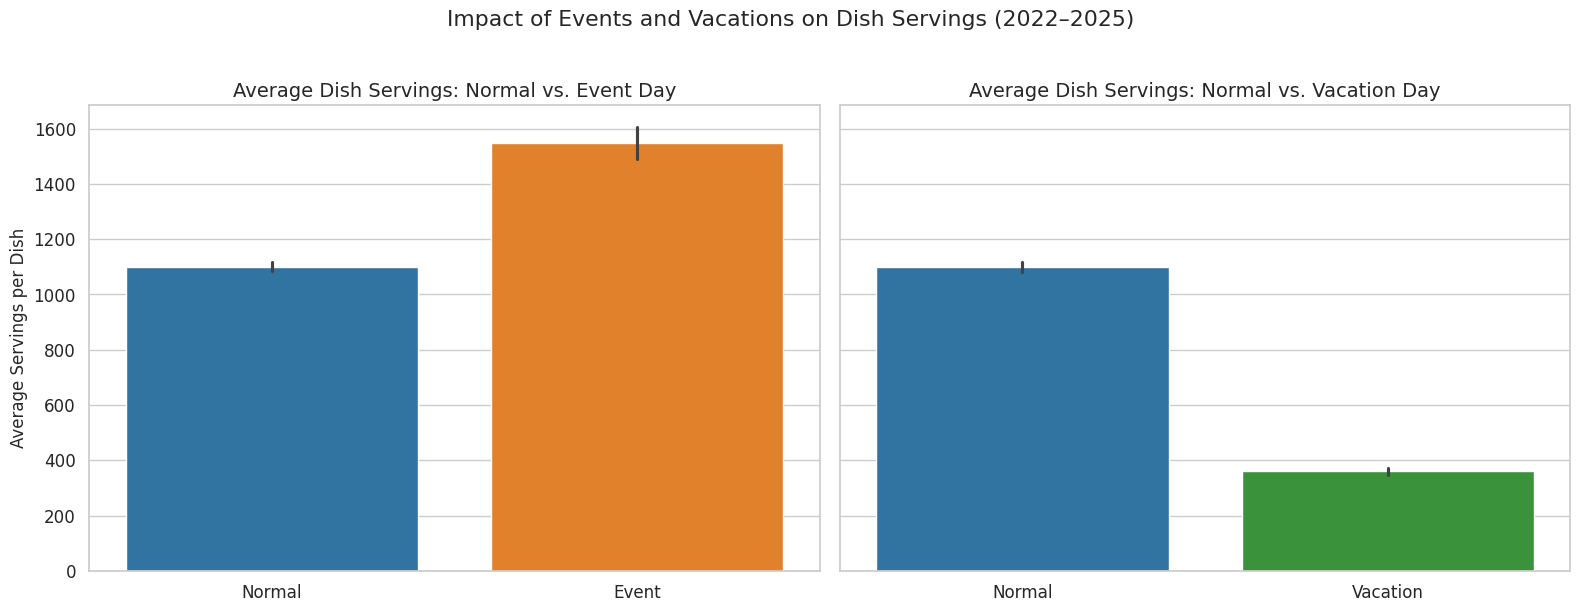

Plotting: 2. Average Servings by Meal Type


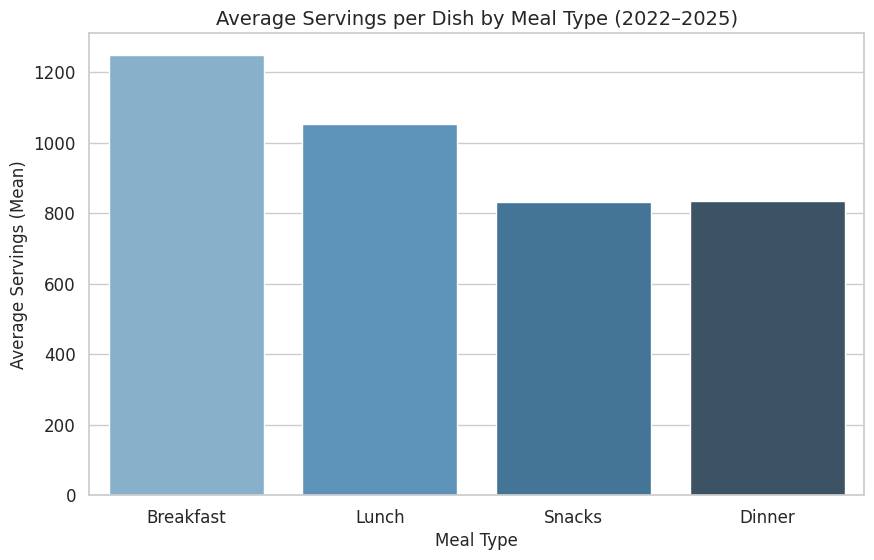

Plotting: 3. Total Daily Servings (Time-Series)


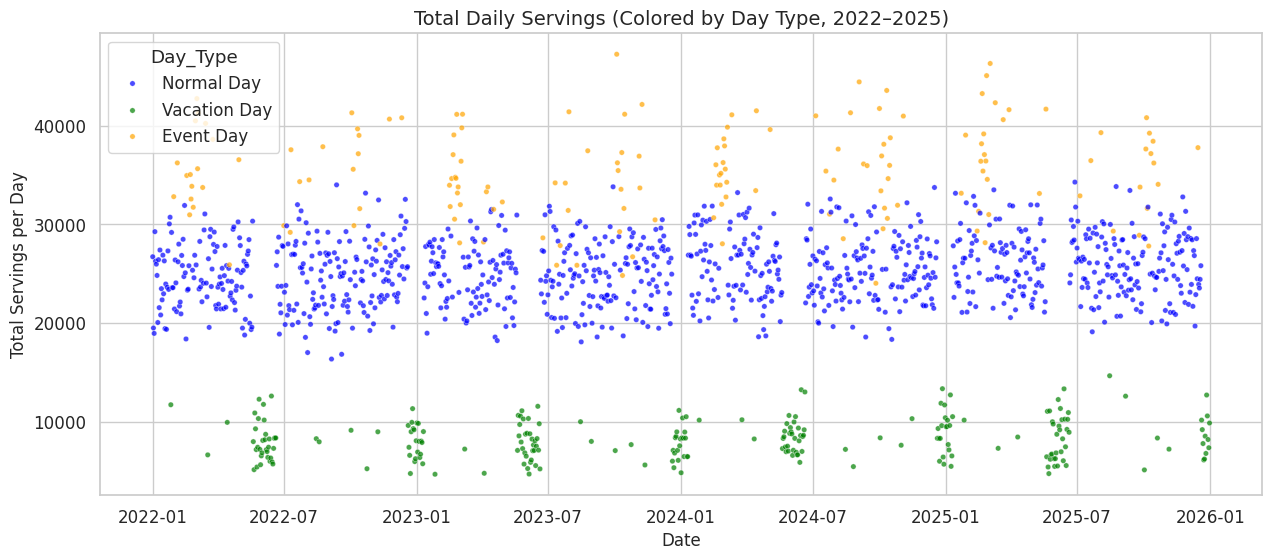

Plotting: 4. Top 20 Popular Dishes


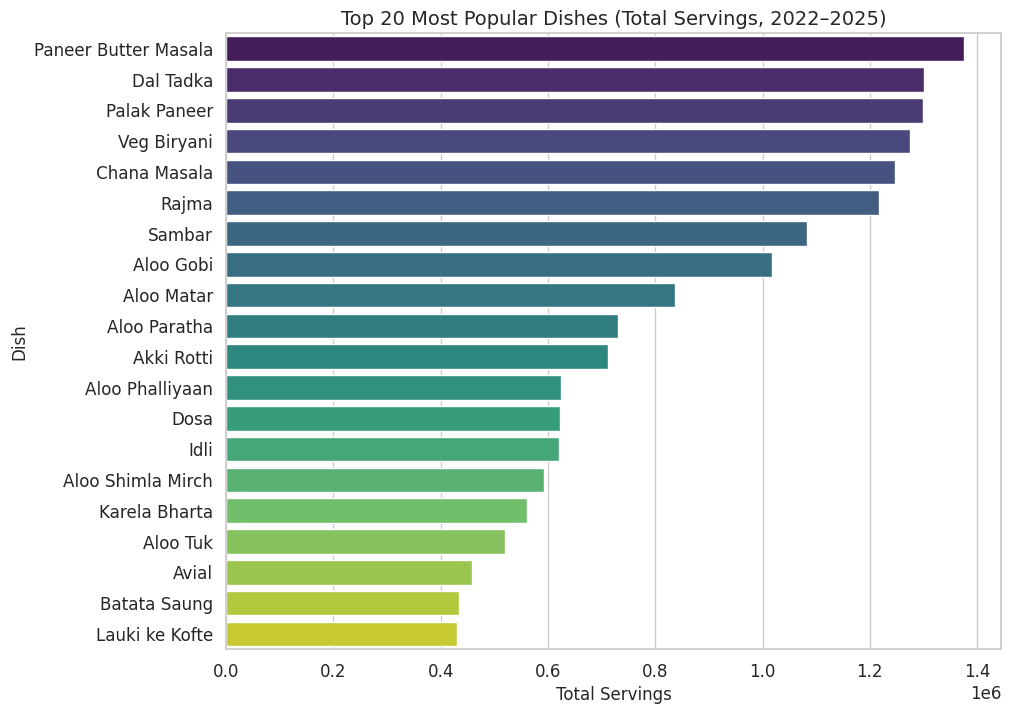

Plotting: 5. Feature Correlation Heatmap


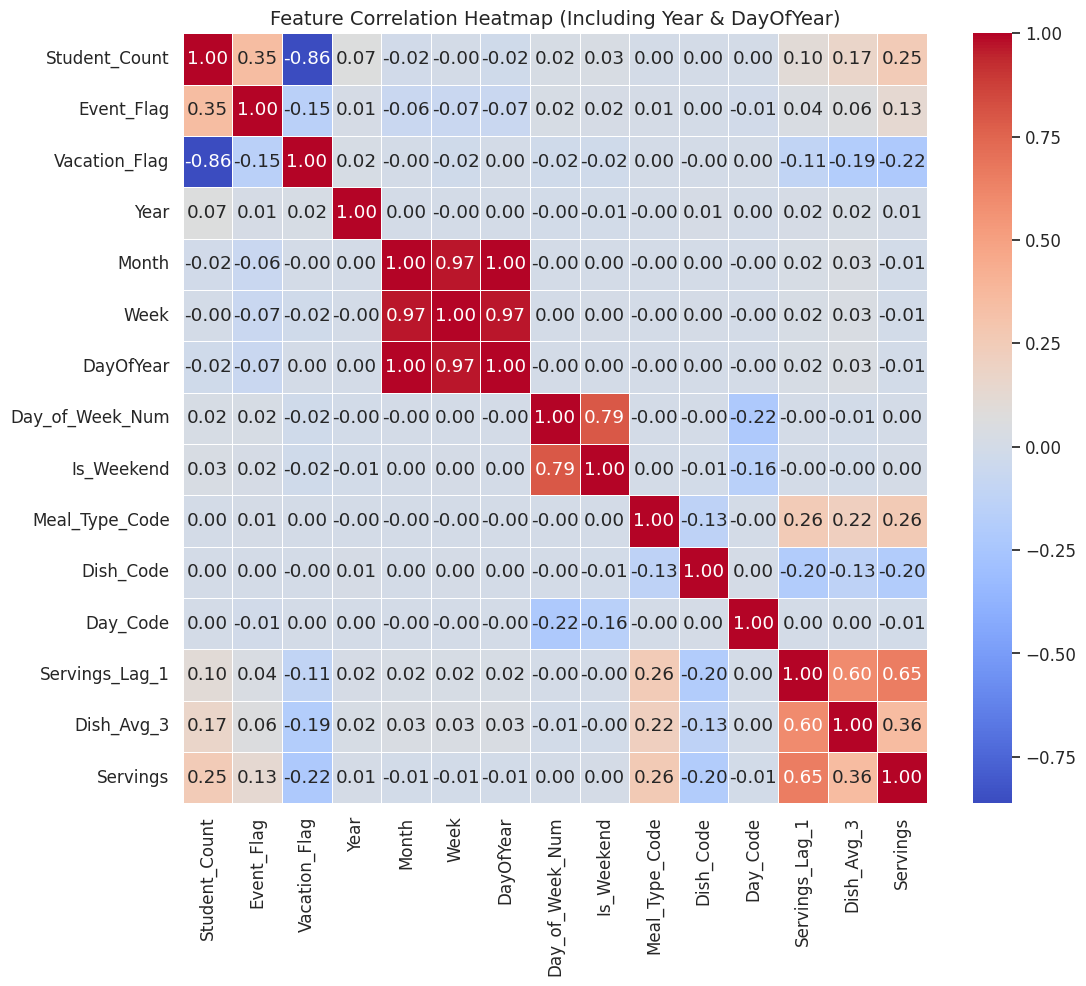

Plotting: 6. Key Predictor Relationships


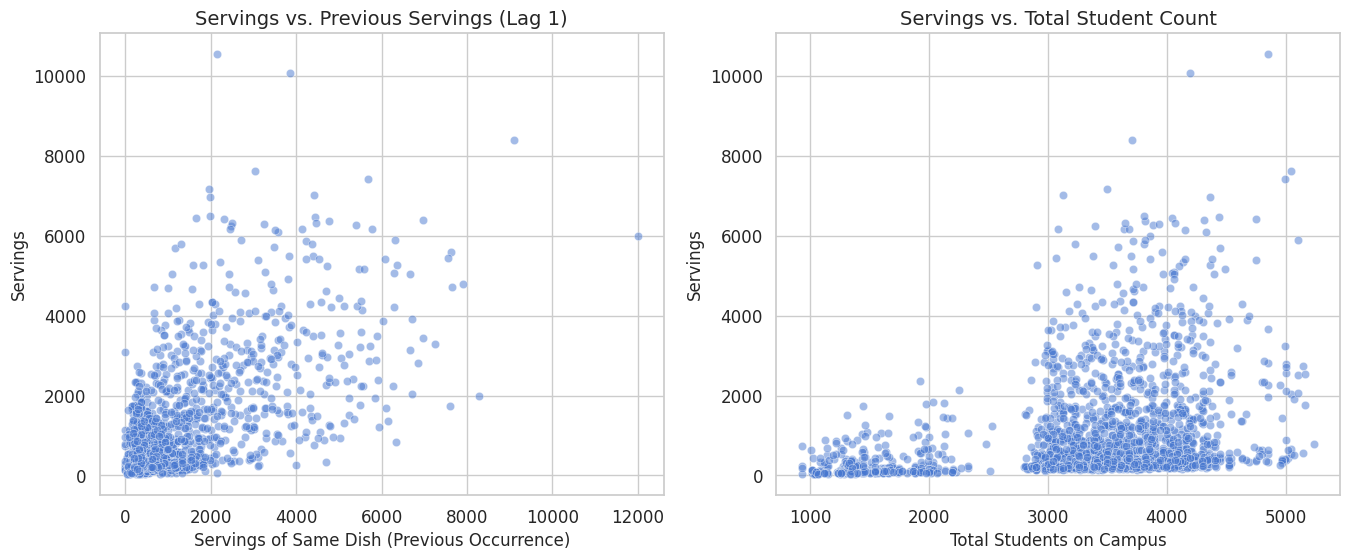


Cell 5: EDA complete. All plots saved to 'figures' directory.

Proceed to Cell 6 for Model Training.


In [6]:
# ================================================================
# CELL 5: Exploratory Data Analysis (EDA) & Visualization
# ================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

print("Starting Cell 5: Exploratory Data Analysis...")

# --- Step 1: Load Data ---
FEATURE_FILE = DATA_PATH / "data_02_featured.parquet"
ORIG_FILE = DATA_PATH / "data_01_loaded.parquet"

if not FEATURE_FILE.exists() or not ORIG_FILE.exists():
    print("ERROR: Data files not found.")
    print("Please re-run Cell 3 and Cell 4 to generate these files:")
    print(f"  {ORIG_FILE}")
    print(f"  {FEATURE_FILE}")
    raise FileNotFoundError("Missing data files. Please run previous cells.")

df_feat = pd.read_parquet(FEATURE_FILE)
df_orig = pd.read_parquet(ORIG_FILE)

# Combine them for easy visualization (indices should match from Cell 4)
df_viz = pd.concat(
    [
        df_feat,
        df_orig[["Date", "Dish_Name", "Meal_Type", "Day"]],
    ],
    axis=1,
)

date_min, date_max = df_viz["Date"].min(), df_viz["Date"].max()
print(f"Loaded data for visualization (shape: {df_viz.shape})")
print(f"Date range: {date_min.date()} to {date_max.date()}")

# --- Step 2: Event/Vacation Impact Analysis ---
print("Plotting: 1. Impact of Events & Vacations on Servings")

df_viz["Day_Type_Plot"] = "Normal"
df_viz.loc[df_viz["Event_Flag"] == 1, "Day_Type_Plot"] = "Event"
df_viz.loc[df_viz["Vacation_Flag"] == 1, "Day_Type_Plot"] = "Vacation"

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1a: Normal vs. Event
sns.barplot(
    data=df_viz[df_viz["Day_Type_Plot"].isin(["Normal", "Event"])],
    x="Day_Type_Plot",
    y="Servings",
    ax=axes[0],
    palette={"Normal": "#1f77b4", "Event": "#ff7f0e"},
)
axes[0].set_title("Average Dish Servings: Normal vs. Event Day")
axes[0].set_xlabel("")
axes[0].set_ylabel("Average Servings per Dish")

# Plot 1b: Normal vs. Vacation
sns.barplot(
    data=df_viz[df_viz["Day_Type_Plot"].isin(["Normal", "Vacation"])],
    x="Day_Type_Plot",
    y="Servings",
    ax=axes[1],
    palette={"Normal": "#1f77b4", "Vacation": "#2ca02c"},
)
axes[1].set_title("Average Dish Servings: Normal vs. Vacation Day")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.suptitle("Impact of Events and Vacations on Dish Servings (2022–2025)", y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_PATH / "eda_01_event_vacation_impact.png", bbox_inches="tight")
plt.show()

# --- Step 3: Average Servings by Meal Type ---
print("Plotting: 2. Average Servings by Meal Type")
avg_servings_meal = df_viz.groupby("Meal_Type")["Servings"].mean().reset_index()
meal_order = ["Breakfast", "Lunch", "Snacks", "Dinner"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_servings_meal,
    x="Meal_Type",
    y="Servings",
    order=meal_order,
    palette="Blues_d",
)
plt.title("Average Servings per Dish by Meal Type (2022–2025)")
plt.ylabel("Average Servings (Mean)")
plt.xlabel("Meal Type")
plt.savefig(FIGURES_PATH / "eda_02_avg_servings_by_meal.png", bbox_inches="tight")
plt.show()

# --- Step 4: Time-Series Overview of Total Daily Servings ---
print("Plotting: 3. Total Daily Servings (Time-Series)")
daily_demand = (
    df_viz.groupby(["Date", "Event_Flag", "Vacation_Flag"])["Servings"]
    .sum()
    .reset_index()
)
daily_demand["Day_Type"] = "Normal Day"
daily_demand.loc[daily_demand["Event_Flag"] == 1, "Day_Type"] = "Event Day"
daily_demand.loc[daily_demand["Vacation_Flag"] == 1, "Day_Type"] = "Vacation Day"

plt.figure(figsize=(15, 6))
sns.scatterplot(
    data=daily_demand,
    x="Date",
    y="Servings",
    hue="Day_Type",
    palette={"Normal Day": "blue", "Event Day": "orange", "Vacation Day": "green"},
    s=15,
    alpha=0.7,
)
plt.title("Total Daily Servings (Colored by Day Type, 2022–2025)")
plt.ylabel("Total Servings per Day")
plt.xlabel("Date")
plt.savefig(FIGURES_PATH / "eda_03_daily_servings_timeline.png", bbox_inches="tight")
plt.show()

# --- Step 5: Top 20 Popular Dishes ---
print("Plotting: 4. Top 20 Popular Dishes")
top_20_dishes = (
    df_orig.groupby("Dish_Name")["Servings"]
    .sum()
    .nlargest(20)
    .reset_index()
)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_20_dishes,
    x="Servings",
    y="Dish_Name",
    palette="viridis",
)
plt.title("Top 20 Most Popular Dishes (Total Servings, 2022–2025)")
plt.xlabel("Total Servings")
plt.ylabel("Dish")
plt.savefig(FIGURES_PATH / "eda_04_top_20_dishes.png", bbox_inches="tight")
plt.show()

# --- Step 6: Feature Correlation Heatmap ---
print("Plotting: 5. Feature Correlation Heatmap")
plt.figure(figsize=(12, 10))
corr_matrix = df_feat.corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
)
plt.title("Feature Correlation Heatmap (Including Year & DayOfYear)")
plt.savefig(FIGURES_PATH / "eda_05_correlation_heatmap.png", bbox_inches="tight")
plt.show()

# --- Step 7: Key Predictor Relationships ---
print("Plotting: 6. Key Predictor Relationships")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sample 2000 points to avoid overplotting
sample_df = df_feat.sample(2000, random_state=SEED)

sns.scatterplot(
    data=sample_df,
    x="Servings_Lag_1",
    y="Servings",
    alpha=0.5,
    ax=axes[0],
)
axes[0].set_title("Servings vs. Previous Servings (Lag 1)")
axes[0].set_xlabel("Servings of Same Dish (Previous Occurrence)")

sns.scatterplot(
    data=sample_df,
    x="Student_Count",
    y="Servings",
    alpha=0.5,
    ax=axes[1],
)
axes[1].set_title("Servings vs. Total Student Count")
axes[1].set_xlabel("Total Students on Campus")

plt.savefig(FIGURES_PATH / "eda_06_key_predictor_scatter.png", bbox_inches="tight")
plt.show()

print("\nCell 5: EDA complete. All plots saved to 'figures' directory.")
print("\nProceed to Cell 6 for Model Training.")


### Cell 6 - Baseline Model Training (Time-Series)

This cell builds our first forecasting benchmarks on the engineered features (`data_02_featured.parquet`).

- **Time-aware split:** Data is split chronologically (first 80% train, last 20% test), so models are always predicting **future days from past days** and no data leakage occurs.
- **Models compared:** We train four baselines – Linear Regression, Random Forest, Gradient Boosting, and XGBoost – and clamp any negative predictions to 0 (since servings cannot be negative).
- **Metrics used:** For each model we compute **MAE, RMSE, and MAPE** on the held-out test period (March–Dec 2025).
- **Key result:** Among all baselines, the **Random Forest** achieves the **lowest RMSE (~727)** and is saved as `baseline_best_model.pkl` for comparison with later tuned models.


In [9]:
# ================================================================
# CELL 6: Baseline Model Training
# ================================================================
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

print("Starting Cell 6: Baseline Model Training...")

# --- PRE-REQUISITES (from Cell 1) ---
# If running standalone, uncomment these:
WORKDIR = Path("/content/SmartBite")
DATA_PATH = WORKDIR / "data"
REPORTS_PATH = WORKDIR / "reports"
MODELS_PATH = WORKDIR / "models"
SEED = 42

REPORTS_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)

# Model Imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
try:
    from xgboost import XGBRegressor
except ImportError:
    XGBRegressor = None  # Set to None if not found
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Step 1: Load Featured Data ---
INPUT_FILE = DATA_PATH / "data_02_featured.parquet"
if not INPUT_FILE.exists():
    raise FileNotFoundError(f"File not found: {INPUT_FILE}. Please re-run Cell 4.")

df_featured = pd.read_parquet(INPUT_FILE)
X = df_featured.drop("Servings", axis=1)
y = df_featured["Servings"]

print(f"Loaded featured data: X shape {X.shape}, y shape {y.shape}")

# --- Step 2: Time-Series Split (80/20) ---
test_size = 0.2
split_point = int(len(df_featured) * (1 - test_size))

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Load original data just to print the date range (for validation)
try:
    df_orig = pd.read_parquet(DATA_PATH / "data_01_loaded.parquet")
    print(f"Time-series split: Train shape {X_train.shape}, Test shape {X_test.shape}")
    print(f"  Training data from: {df_orig['Date'].iloc[0].date()} "
          f"to {df_orig['Date'].iloc[split_point].date()}")
    print(f"  Testing data from:  {df_orig['Date'].iloc[split_point+1].date()} "
          f"to {df_orig['Date'].iloc[-1].date()}")
except FileNotFoundError:
    print(f"Time-series split: Train shape {X_train.shape}, Test shape {X_test.shape}")

# --- Step 3: Helper Function (Robust MAPE) ---
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = np.maximum(preds, 0)  # clamp negatives to 0

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    # Robust MAPE (ignore very small true values)
    mask = y_test > 1
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_test[mask] - preds[mask]) / y_test[mask])) * 100
    else:
        mape = np.nan

    return mae, rmse, mape

# --- Step 4: Train Baseline Models ---
results = {}
models = {}

# 1. Linear Regression
lr = LinearRegression()
results["Linear Regression"] = evaluate_model("Linear Regression", lr, X_train, X_test, y_train, y_test)
models["Linear Regression"] = lr

# 2. Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=SEED,
    n_jobs=-1,
)
results["Random Forest"] = evaluate_model("Random Forest", rf, X_train, X_test, y_train, y_test)
models["Random Forest"] = rf

# 3. Gradient Boosting
gbr = GradientBoostingRegressor(
    n_estimators=100,
    random_state=SEED,
)
results["Gradient Boosting"] = evaluate_model("Gradient Boosting", gbr, X_train, X_test, y_train, y_test)
models["Gradient Boosting"] = gbr

# 4. XGBoost (if available)
if XGBRegressor:
    xgb = XGBRegressor(
        n_estimators=100,
        random_state=SEED,
        n_jobs=-1,
        objective="reg:squarederror",
        tree_method="hist",
    )
    results["XGBoost"] = evaluate_model("XGBoost", xgb, X_train, X_test, y_train, y_test)
    models["XGBoost"] = xgb
else:
    print("\nSkipping XGBoost (not installed or error during import)")

# --- Step 5: Display & Save Results ---
results_df = pd.DataFrame(results, index=["MAE", "RMSE", "MAPE"]).T
results_df = results_df.sort_values(by="RMSE")

print("\nBaseline Model Evaluation Completed!")
display(results_df)

# Save results to reports
RESULTS_FILE = REPORTS_PATH / "baseline_model_results.csv"
results_df.to_csv(RESULTS_FILE)
print(f"Results saved to {RESULTS_FILE}")

# --- Step 6: Save Best Baseline Model ---
best_model_name = results_df.index[0]
best_model = models[best_model_name]

MODEL_FILE = MODELS_PATH / "baseline_best_model.pkl"
joblib.dump(best_model, MODEL_FILE)
print(f"Best baseline model ({best_model_name}) saved to {MODEL_FILE}")

print("\nProceed to Cell 7 for Model Tuning.")


Starting Cell 6: Baseline Model Training...
Loaded featured data: X shape (33567, 14), y shape (33567,)
Time-series split: Train shape (26853, 14), Test shape (6714, 14)
  Training data from: 2022-01-01 to 2025-03-15
  Testing data from:  2025-03-15 to 2025-12-31

Training Linear Regression...

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Baseline Model Evaluation Completed!


,MAE,RMSE,MAPE
Random Forest,465.04,727.34,76.59
XGBoost,458.58,736.33,67.25
Gradient Boosting,481.60,767.93,77.33
Linear Regression,592.26,944.68,98.40


Results saved to /content/SmartBite/reports/baseline_model_results.csv
Best baseline model (Random Forest) saved to /content/SmartBite/models/baseline_best_model.pkl

Proceed to Cell 7 for Model Tuning.


### Cell 7 – Model Tuning and Final Model Selection

This cell fine-tunes our best tree models and selects the final production model.

- Uses **RandomizedSearchCV** with **TimeSeriesSplit (3 folds)** to tune **Random Forest** and **XGBoost** while strictly respecting time order (no data leakage).
- Evaluates tuned models on the same 20% test window using **MAE, RMSE, and MAPE**, then compares them with the best baseline from Cell 6.
- Result: **Tuned XGBoost** becomes the final model with the **lowest RMSE (~705)** and improved error metrics over the baseline Random Forest.
- Saves this model as `final_best_model.pkl` and plots:
  - **Final Model Comparison** (RMSE across Tuned XGBoost, Tuned RF, and Baseline RF).
  - **Top 15 Feature Importances**, confirming `Servings_Lag_1`, `Dish_Code`, `Meal_Type_Code`, and event/vacation flags as the key drivers of predicted demand.


Starting Cell 7: Model Tuning...
Loaded data for tuning: Train shape (26853, 14), Test shape (6714, 14)
Using TimeSeriesSplit(n_splits=3) for cross-validation.

Tuning Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}

Tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost params: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 0.7}

Evaluating tuned models on test set...
Evaluating Tuned Random Forest...
Evaluating Tuned XGBoost...

Tuned Model Evaluation Completed!


,MAE,RMSE,MAPE
Tuned XGBoost,443.28,704.80,66.79
Tuned Random Forest,454.35,722.49,71.31
Baseline (Random Forest),465.04,727.34,76.59


Tuned results saved to /content/SmartBite/reports/final_tuned_model_results.csv
New best model (Tuned XGBoost) saved to /content/SmartBite/models/final_best_model.pkl
Plotting final comparison and feature importance...


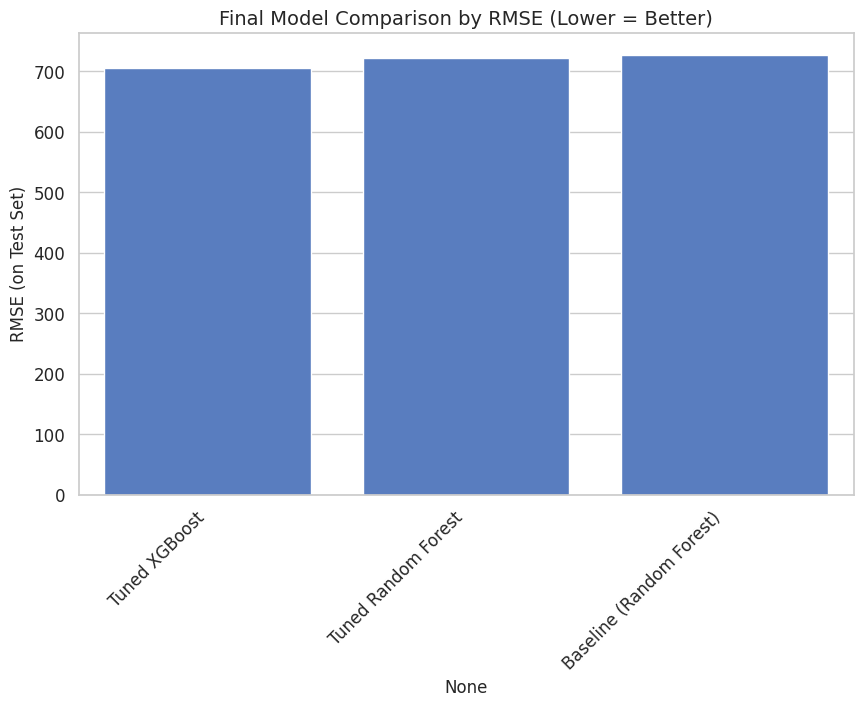

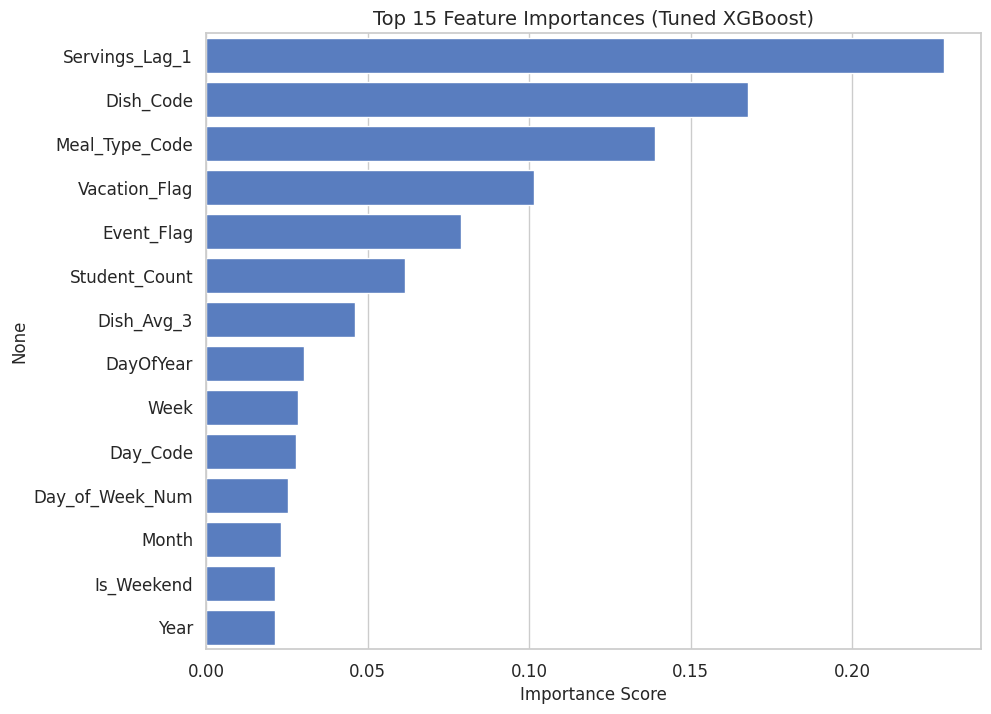


Proceed to Cell 8 for Forecasting.


In [10]:
# ===============================
# CELL 7: Model Tuning
# ===============================
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting Cell 7: Model Tuning...")

# --- PRE-REQUISITES (from Cell 1) ---
# If running standalone, uncomment these:
WORKDIR = Path("/content/SmartBite")
DATA_PATH = WORKDIR / "data"
REPORTS_PATH = WORKDIR / "reports"
MODELS_PATH = WORKDIR / "models"
FIGURES_PATH = WORKDIR / "figures"
SEED = 42

# Ensure paths exist for saving
REPORTS_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# Model Imports
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Step 1: Load Featured Data (Same as Cell 6) ---
INPUT_FILE = DATA_PATH / "data_02_featured.parquet"
if not INPUT_FILE.exists():
    raise FileNotFoundError(f"File not found: {INPUT_FILE}. Please re-run Cell 4.")

df_featured = pd.read_parquet(INPUT_FILE)
X = df_featured.drop("Servings", axis=1)
y = df_featured["Servings"]

# --- Step 2: Time-Series Train/Test Split (80/20, same as Cell 6) ---
test_size = 0.2
split_point = int(len(df_featured) * (1 - test_size))

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Loaded data for tuning: Train shape {X_train.shape}, Test shape {X_test.shape}")

# --- Step 3: Helper Function (Evaluation) ---
def evaluate_model(model_name, model, X_test, y_test):
    print(f"Evaluating {model_name}...")
    preds = model.predict(X_test)
    preds = np.maximum(preds, 0)  # clamp negative servings to 0

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    mask = y_test > 1
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_test[mask] - preds[mask]) / y_test[mask])) * 100
    else:
        mape = np.nan

    return mae, rmse, mape

# --- Step 4: Time-Series Cross-Validator ---
# We will use 3 splits. This object will be passed to RandomizedSearchCV.
tscv = TimeSeriesSplit(n_splits=3)
print("Using TimeSeriesSplit(n_splits=3) for cross-validation.")

# --- Step 5: Tune Random Forest ---
print("\nTuning Random Forest...")
rf_params = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=SEED, n_jobs=-1),
    param_distributions=rf_params,
    n_iter=10, # Number of parameter settings to sample (more scalable)
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=SEED,
)
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
print(f"Best Random Forest params: {rf_random.best_params_}")

# --- Step 6: Tune XGBoost (with RandomizedSearchCV) ---
print("\nTuning XGBoost...")
xgb_params = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
}
xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(
        random_state=SEED,
        n_jobs=-1,
        objective="reg:squarederror",
        tree_method="hist",
    ),
    param_distributions=xgb_params,
    n_iter=10,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=SEED,
)
xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_
print(f"Best XGBoost params: {xgb_random.best_params_}")

# --- Step 7: Evaluate Tuned Models & Compare to Baseline ---
print("\nEvaluating tuned models on test set...")
tuned_results = {}
tuned_results["Tuned Random Forest"] = evaluate_model("Tuned Random Forest", best_rf, X_test, y_test)
tuned_results["Tuned XGBoost"] = evaluate_model("Tuned XGBoost", best_xgb, X_test, y_test)

# Load best baseline for comparison
baseline_results = pd.read_csv(REPORTS_PATH / "baseline_model_results.csv", index_col=0)
best_baseline = baseline_results.iloc[0:1]  # top row is best (sorted by RMSE there)
best_baseline = best_baseline.rename(
    index={best_baseline.index[0]: f"Baseline ({best_baseline.index[0]})"}
)

# Combine and display
tuned_df = pd.DataFrame(tuned_results, index=["MAE", "RMSE", "MAPE"]).T
final_results_df = pd.concat([tuned_df, best_baseline])
final_results_df = final_results_df.sort_values(by="RMSE")

print("\nTuned Model Evaluation Completed!")
display(final_results_df)

# Save final results
final_results_file = REPORTS_PATH / "final_tuned_model_results.csv"
final_results_df.to_csv(final_results_file)
print(f"Tuned results saved to {final_results_file}")

# --- Step 8: Save Best Overall Model ---
best_model_name = final_results_df.index[0]

# Default: assume tuned models are best; adjust if baseline wins
if "Tuned Random Forest" in best_model_name:
    best_model = best_rf
elif "Tuned XGBoost" in best_model_name:
    best_model = best_xgb
else:
    # Baseline is best → load it
    best_model = joblib.load(MODELS_PATH / "baseline_best_model.pkl")

# Only save if it's a tuned model
if "Tuned" in best_model_name:
    joblib.dump(best_model, MODELS_PATH / "final_best_model.pkl")
    print(f"New best model ({best_model_name}) saved to {MODELS_PATH / 'final_best_model.pkl'}")
else:
    print(f"Best model remains the baseline: {best_model_name}")

# --- Step 9: Visualization & Feature Importance ---
print("Plotting final comparison and feature importance...")

# Plot 1: Final Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=final_results_df.index, y=final_results_df["RMSE"])
plt.title("Final Model Comparison by RMSE (Lower = Better)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE (on Test Set)")
plt.savefig(FIGURES_PATH / "final_model_comparison_rmse.png", bbox_inches="tight")
plt.show()

# Plot 2: Feature Importance (from the new best tree model)
if "Tuned" in best_model_name:  # only for tuned tree-based models
    importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances.head(15), y=importances.head(15).index)
    plt.title(f"Top 15 Feature Importances ({best_model_name})")
    plt.xlabel("Importance Score")
    plt.savefig(FIGURES_PATH / "final_feature_importance.png", bbox_inches="tight")
    plt.show()

print("\nProceed to Cell 8 for Forecasting.")


### Cell 7b - Model Explainability with SHAP (Final Best Model)

This cell provides **interpretability** for our final tuned model (Tuned XGBoost) using **SHAP values**, helping us understand *why* the model makes certain predictions.

#### Key Highlights

- **Model & Data Setup:**  
  The cell loads the final best model (`final_best_model.pkl`) and uses the same 80/20 time-series split as earlier cells. A sample of **2,000 test rows** is selected for SHAP analysis to keep computation efficient.

- **Global Feature Impact (SHAP Summary Plot):**  
  The summary plot confirms the most influential predictors:
  - **Servings_Lag_1** (strongest driver of predictions)  
  - **Dish_Code** and **Meal_Type_Code**  
  - **Student_Count**, **Event_Flag**, and **Vacation_Flag**

  High feature values (pink) push predictions up, while low values (blue) push them down.

- **Detailed Impact of Top Feature:**  
  The SHAP dependence plot for **Servings_Lag_1** shows a clear, positive trend—  
  **higher previous servings lead to higher predicted servings**.  
  The color (Dish_Code) indicates this trend holds consistently across many dishes.

- **Why This Matters:**  
  The SHAP results demonstrate that the model is capturing meaningful real-world patterns (past demand, dish identity, campus population size, events, vacations), making the final forecasts **transparent, interpretable, and trustworthy**.


In [11]:
# ================================================================
# CELL 7b: Model Explainability with SHAP (Final Best Model)
# ================================================================
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

# --- PRE-REQUISITES (same as other cells) ---
# If running standalone, uncomment:
WORKDIR = Path("/content/SmartBite")
DATA_PATH = WORKDIR / "data"
MODELS_PATH = WORKDIR / "models"
FIGURES_PATH = WORKDIR / "figures"
SEED = 42

FEATURED_FILE = DATA_PATH / "data_02_featured.parquet"

print(f"Loading featured dataset from: {FEATURED_FILE}")
df_featured = pd.read_parquet(FEATURED_FILE)

X = df_featured.drop("Servings", axis=1)
y = df_featured["Servings"]

# Same time-series split logic as Cell 6 / Cell 7
test_size = 0.2
split_point = int(len(df_featured) * (1 - test_size))
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# --- Load final best model ---
MODEL_FILE = MODELS_PATH / "final_best_model.pkl"
best_model = joblib.load(MODEL_FILE)
print(f"Loaded final best model from {MODEL_FILE}")
print("Model type:", type(best_model))

# --- Build SHAP explainer (tree-based) ---
shap.initjs()

SAMPLE_SIZE = min(2000, len(X_test))
X_sample = X_test.sample(n=SAMPLE_SIZE, random_state=SEED)
print(f"Using SHAP on a sample of {len(X_sample)} rows from X_test")

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)

# --- SHAP Summary Plot ---
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_sample, show=False)
plt.tight_layout()
shap_summary_path = FIGURES_PATH / "shap_summary_final_model.png"
plt.savefig(shap_summary_path, bbox_inches="tight")
plt.close()
print(f"SHAP summary plot saved to: {shap_summary_path}")

# --- SHAP Dependence Plot for Top Feature ---
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_feature = importances.index[0]
print("Top feature by importance:", top_feature)

shap.dependence_plot(top_feature, shap_values, X_sample, show=False)
plt.tight_layout()
dep_path = FIGURES_PATH / f"shap_dependence_{top_feature}.png"
plt.savefig(dep_path, bbox_inches="tight")
plt.close()
print(f"SHAP dependence plot for {top_feature} saved to: {dep_path}")

print("\nCell 7b: SHAP explainability complete. Proceed to Cell 8 for Forecasting.")


Loading featured dataset from: /content/SmartBite/data/data_02_featured.parquet
X_train: (26853, 14), X_test: (6714, 14)
Loaded final best model from /content/SmartBite/models/final_best_model.pkl
Model type: <class 'xgboost.sklearn.XGBRegressor'>


Using SHAP on a sample of 2000 rows from X_test
Generating SHAP summary plot...
SHAP summary plot saved to: /content/SmartBite/figures/shap_summary_final_model.png
Top feature by importance: Servings_Lag_1
SHAP dependence plot for Servings_Lag_1 saved to: /content/SmartBite/figures/shap_dependence_Servings_Lag_1.png

Cell 7b: SHAP explainability complete. Proceed to Cell 8 for Forecasting.


### Cell 8 - Future Forecasting (Next 7 Days)

This cell uses our final tuned model (**Tuned XGBoost**) to generate a **7-day ahead forecast** for every dish–meal combination served historically.

#### What This Cell Does

- **Loads the final model and all saved encoders**  
  Ensures consistent preprocessing when preparing future data.

- **Defines the forecasting window:**  
  Forecast starts on the day *after* the last historical date (2025-12-31 → 2026-01-01).

- **Creates future rows for every date × (dish, meal) pair**, replicating:
  - Temporal features (Year, Month, Week, DayOfYear, Weekend flag)
  - Encoded categorical features
  - Contextual assumptions (Student_Count, Event/Vacation flags)

- **Reconstructs lag features** using the *last known* occurrence of each dish & meal.

- **Generates predictions** using the trained model and stores them in `Predicted_Servings`.

#### Key Insights from Forecast

- **Snacks** show the highest expected demand over the next 7 days.  
- **Lunch** and **Dinner** follow with moderate demand, while **Breakfast** remains lower.  
- Top predicted dishes include **Chana Masala, Sambar, Rajma, Aloo Gobi**, and **Palak Paneer** — consistent with historical popularity.

#### Output Artifacts

- Bar chart saved as: `forecast_avg_by_meal.png`
- Full forecast saved as: `forecast_next7days.csv`
- Displayed tables list:
  - **Top 15 dishes by predicted total demand**
  - **Sample of day-wise predictions**

This completes the forecasting pipeline and prepares results for downstream reporting or dashboard deployment.


Generating next 7 days forecast...
Loaded model: XGBRegressor
Loaded 144 dishes, 4 meals, 7 days.
Last historical date: 2025-12-31
Forecast horizon: 2026-01-01 to 2026-01-07
Using last known Student_Count as default: 1948
Forecast generated successfully.


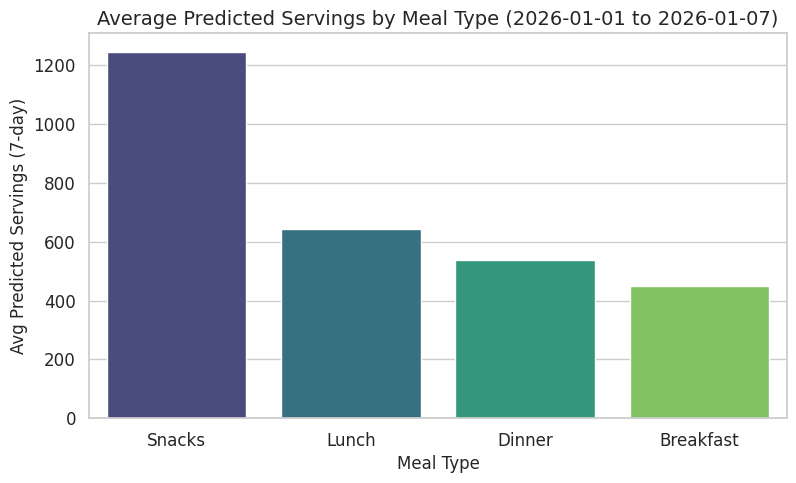


Top 15 dishes by cumulative predicted servings (next 7 days):


,Dish_Name,Predicted_Servings
0,Chana Masala,28317
1,Sambar,25748
2,Rajma,24070
3,Aloo Gobi,24022
4,Palak Paneer,20462
5,Pav Bhaji,19967
6,Paneer Butter Masala,18164
7,Aloo Matar,16937
8,Dal Tadka,16669
9,Aloo Shimla Mirch,16493



Sample of predicted rows (demand > 20):


,Date,Day,Meal_Type,Dish_Name,Predicted_Servings
0,2026-01-01,Thursday,Breakfast,Pongal,965
1,2026-01-01,Thursday,Breakfast,Akki Rotti,1549
2,2026-01-01,Thursday,Breakfast,Upma,188
3,2026-01-01,Thursday,Breakfast,Poha,405
4,2026-01-01,Thursday,Breakfast,Idli,902
5,2026-01-01,Thursday,Breakfast,Uttapam,1333
6,2026-01-01,Thursday,Breakfast,Dibba Rotti,338
7,2026-01-01,Thursday,Lunch,Jeera Aloo,381
8,2026-01-01,Thursday,Lunch,Khoya Paneer,296
9,2026-01-01,Thursday,Lunch,Jeera Rice,266



Forecast saved to: /content/SmartBite/reports/forecast_next7days.csv

Proceed to Cell 9 for Preference Analysis.


In [12]:
# ===================================
# CELL 8: Future Forecasting
# ===================================
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# --- PRE-REQUISITES (from Cell 1) ---
# If running standalone, uncomment these:
# WORKDIR = Path("/content/SmartBite")
# SEED = 42

DATA_PATH = WORKDIR / "data"
MODELS_PATH = WORKDIR / "models"
FIGURES_PATH = WORKDIR / "figures"
REPORTS_PATH = WORKDIR / "reports"

FIGURES_PATH.mkdir(parents=True, exist_ok=True)
REPORTS_PATH.mkdir(parents=True, exist_ok=True)

print("Generating next 7 days forecast...")

# --- Step 1: Load Model & Encoders ---
try:
    model = joblib.load(MODELS_PATH / "final_best_model.pkl")
    le_meal = joblib.load(MODELS_PATH / "le_meal_encoder.pkl")
    le_dish = joblib.load(MODELS_PATH / "le_dish_encoder.pkl")
    le_day = joblib.load(MODELS_PATH / "le_day_encoder.pkl")
except FileNotFoundError:
    print("ERROR: Model or encoder files not found. Please re-run Cells 4 and 7.")
    raise

print(f"Loaded model: {model.__class__.__name__}")
print(
    f"Loaded {le_dish.classes_.size} dishes, "
    f"{le_meal.classes_.size} meals, {le_day.classes_.size} days."
)

# --- Step 2: Load original & featured data, find last date ---
df_orig = pd.read_parquet(DATA_PATH / "data_01_loaded.parquet")
df_feat = pd.read_parquet(DATA_PATH / "data_02_featured.parquet")

last_date = df_orig["Date"].max()
future_start = last_date + pd.Timedelta(days=1)
future_end = future_start + pd.Timedelta(days=6)  # 7 days total
future_dates = pd.date_range(start=future_start, end=future_end, freq="D")

print(f"Last historical date: {last_date.date()}")
print(f"Forecast horizon: {future_start.date()} to {future_end.date()}")

# Combine to get Dish_Name + Meal_Type + latest lag features
df_full_feat = pd.concat(
    [df_orig[["Dish_Name", "Meal_Type"]], df_feat.reset_index(drop=True)], axis=1
)

# Get last known row per (Dish_Name, Meal_Type)
last_known_features = (
    df_full_feat
    .groupby(["Dish_Name", "Meal_Type"])
    .last()
    .reset_index()
)

student_count_default = df_orig["Student_Count"].iloc[-1]
print(f"Using last known Student_Count as default: {student_count_default}")

# Unique dish–meal pairs seen historically (realistic menu combinations)
dish_meal_pairs = df_orig[["Dish_Name", "Meal_Type"]].drop_duplicates()

# --- Step 3: Build Future DataFrame (structure only, no predictions yet) ---
future_rows = []
for date in future_dates:
    day_name = date.strftime("%A")
    if day_name not in le_day.classes_:
        print(f"Warning: Day '{day_name}' not in encoder. Skipping.")
        continue

    day_code = int(le_day.transform([day_name])[0])

    for _, pair in dish_meal_pairs.iterrows():
        dish_name = pair["Dish_Name"]
        meal_name = pair["Meal_Type"]

        row = {
            # Identifiers
            "Date": date,
            "Day": day_name,
            "Meal_Type": meal_name,
            "Dish_Name": dish_name,

            # Encoded categorical features
            "Meal_Type_Code": int(le_meal.transform([meal_name])[0]),
            "Dish_Code": int(le_dish.transform([dish_name])[0]),
            "Day_Code": day_code,

            # Temporal features (must match Cell 4)
            "Year": date.year,
            "Month": date.month,
            "Week": int(date.isocalendar().week),
            "DayOfYear": date.timetuple().tm_yday,
            "Day_of_Week_Num": date.weekday(),
            "Is_Weekend": 1 if date.weekday() >= 5 else 0,

            # Contextual features (defaults / assumptions)
            "Student_Count": student_count_default,
            "Event_Flag": 0,     # assume no special event
            "Vacation_Flag": 0,  # assume not in long vacation block
        }
        future_rows.append(row)

future_df = pd.DataFrame(future_rows)

# --- Step 4: Merge Lag Features (per Dish_Name + Meal_Type) ---
features_to_merge = ["Servings_Lag_1", "Dish_Avg_3"]

future_df = future_df.merge(
    last_known_features[["Dish_Name", "Meal_Type"] + features_to_merge],
    on=["Dish_Name", "Meal_Type"],
    how="left",
)

# New or rare combinations → fill lags with 0 (no history)
future_df[features_to_merge] = future_df[features_to_merge].fillna(0)

# --- Step 5: Predict with the trained model ---
model_features = model.feature_names_in_  # guarantees correct order
X_future = future_df[model_features]

preds = model.predict(X_future)
future_df["Predicted_Servings"] = np.round(preds).astype(int)
# Apply a floor of 0
future_df["Predicted_Servings"] = future_df["Predicted_Servings"].clip(lower=0)

print("Forecast generated successfully.")

# --- Step 6: Summaries & Visualizations ---

# Filter out zero / tiny demands for clearer visuals
future_df_viz = future_df[future_df["Predicted_Servings"] > 20]

# Average predicted servings per meal type
forecast_summary = (
    future_df_viz.groupby("Meal_Type")["Predicted_Servings"]
    .mean()
    .reset_index()
    .sort_values(by="Predicted_Servings", ascending=False)
)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=forecast_summary,
    x="Meal_Type",
    y="Predicted_Servings",
    palette="viridis",
)
plt.title(
    f"Average Predicted Servings by Meal Type "
    f"({future_start.date()} to {future_end.date()})"
)
plt.ylabel("Avg Predicted Servings (7-day)")
plt.xlabel("Meal Type")
plt.savefig(FIGURES_PATH / "forecast_avg_by_meal.png", bbox_inches="tight")
plt.show()

# Top 15 dishes by cumulative predicted servings
top_dishes = (
    future_df_viz.groupby("Dish_Name")["Predicted_Servings"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .reset_index()
)

print("\nTop 15 dishes by cumulative predicted servings (next 7 days):")
display(top_dishes)

# Show a small sample forecast table
print("\nSample of predicted rows (demand > 20):")
display(
    future_df_viz[
        ["Date", "Day", "Meal_Type", "Dish_Name", "Predicted_Servings"]
    ].head(20)
)

# --- Step 7: Save forecast to CSV ---
out_forecast_path = REPORTS_PATH / "forecast_next7days.csv"
future_df_viz.to_csv(out_forecast_path, index=False)
print(f"\nForecast saved to: {out_forecast_path}")

print("\nProceed to Cell 9 for Preference Analysis.")


### Cell 9 - Preference Analysis (Association Rule Mining per Meal)

This cell identifies **which dishes students commonly choose together**, helping the cafeteria design smarter **menu pairings, combo offers, and layout decisions**.

#### What This Cell Does
- Runs **Association Rule Mining (Apriori)** separately for each **Meal Type** (Breakfast, Lunch, Snacks, Dinner).  
- Treats each *meal period on a given date* as a **transaction basket** containing all dishes served.
- Extracts rules such as:  
  **“If students take Dish A, they often also take Dish B”**  
  measured using:
  - **Support** → Popularity of the itemset  
  - **Confidence** → Likelihood of B given A  
  - **Lift (>1.0)** → Strength of the association beyond randomness  

#### Key Insights
- Over **30,000 valid association rules** were discovered across all meals.  
- Breakfast and Lunch show the strongest multi-item patterns due to high variety.  
- Several dish pairs show **very high lift (10–20x)**, meaning these combinations occur far more frequently than random chance.  
- The scatter plot visualizes how rule quality varies by meal, using:
  - X-axis: Support (popularity)  
  - Y-axis: Confidence (likelihood)  
  - Bubble size: Lift (strength of association)  
  - Color: Meal Type  

#### Outputs Generated
- Full rules exported to:  
  `association_rules_report_all_meals.csv`
- Top actionable combo suggestions saved to:  
  `menu_recommendations_from_rules.csv`
- Visualization saved as:  
  `association_rules_by_meal.png`

These results directly support **menu optimization** by showing which dishes should be co-promoted, paired, or placed together for improved student satisfaction and reduced decision fatigue.


Starting Cell 9: Preference Analysis (Association Rules per Meal)...
Loaded original data (shape: (33567, 9))
Meal types found: ['Breakfast', 'Lunch', 'Snacks', 'Dinner']

--- Analyzing meal type: Breakfast ---
  Created 1461 transactions for Breakfast.
  One-hot encoding complete.
  Running Apriori with min_support=0.0030 (>= 4 transactions).
  Found 5727 frequent itemsets for Breakfast.

--- Analyzing meal type: Lunch ---
  Created 1461 transactions for Lunch.
  One-hot encoding complete.
  Running Apriori with min_support=0.0030 (>= 4 transactions).
  Found 4513 frequent itemsets for Lunch.

--- Analyzing meal type: Snacks ---
  Created 1461 transactions for Snacks.
  One-hot encoding complete.
  Running Apriori with min_support=0.0030 (>= 4 transactions).
  Found 47 frequent itemsets for Snacks.

--- Analyzing meal type: Dinner ---
  Created 1461 transactions for Dinner.
  One-hot encoding complete.
  Running Apriori with min_support=0.0030 (>= 4 transactions).
  Found 2718 frequen

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,Meal_Type
10854,"(Aloo Gobi, Mushroom Do Pyaza)","(Lauki ke Kofte, Koottu)",0.01,0.01,0.00,0.31,21.74,1.00,0.00,1.43,0.96,0.16,0.30,0.28,Lunch
10855,"(Lauki ke Kofte, Koottu)","(Aloo Gobi, Mushroom Do Pyaza)",0.01,0.01,0.00,0.24,21.74,1.00,0.00,1.30,0.97,0.16,0.23,0.28,Lunch
10856,"(Aloo Gobi, Koottu)","(Lauki ke Kofte, Mushroom Do Pyaza)",0.01,0.02,0.00,0.25,16.60,1.00,0.00,1.31,0.95,0.14,0.24,0.24,Lunch
10857,"(Lauki ke Kofte, Mushroom Do Pyaza)","(Aloo Gobi, Koottu)",0.02,0.01,0.00,0.23,16.60,1.00,0.00,1.28,0.95,0.14,0.22,0.24,Lunch
10858,"(Mushroom Do Pyaza, Koottu)","(Lauki ke Kofte, Aloo Gobi)",0.01,0.02,0.00,0.26,15.38,1.00,0.00,1.33,0.95,0.13,0.25,0.23,Lunch
10859,"(Lauki ke Kofte, Aloo Gobi)","(Mushroom Do Pyaza, Koottu)",0.02,0.01,0.00,0.20,15.38,1.00,0.00,1.23,0.95,0.13,0.19,0.23,Lunch
10860,"(Rasam, Methi Saag)","(Jalfrezi, Dum Aloo)",0.01,0.02,0.00,0.25,15.22,1.00,0.00,1.31,0.95,0.13,0.24,0.23,Lunch
10861,"(Jalfrezi, Dum Aloo)","(Rasam, Methi Saag)",0.02,0.01,0.00,0.21,15.22,1.00,0.00,1.25,0.95,0.13,0.20,0.23,Lunch
10862,"(Rasam, Shahi Paneer)","(Chaulai Saag, Khoya Paneer)",0.02,0.02,0.00,0.22,14.44,1.00,0.00,1.26,0.95,0.12,0.21,0.22,Lunch
10863,"(Chaulai Saag, Khoya Paneer)","(Rasam, Shahi Paneer)",0.02,0.02,0.00,0.23,14.44,1.00,0.00,1.27,0.94,0.12,0.21,0.22,Lunch



Plotting: Association Rules (Support vs. Confidence) by Meal Type


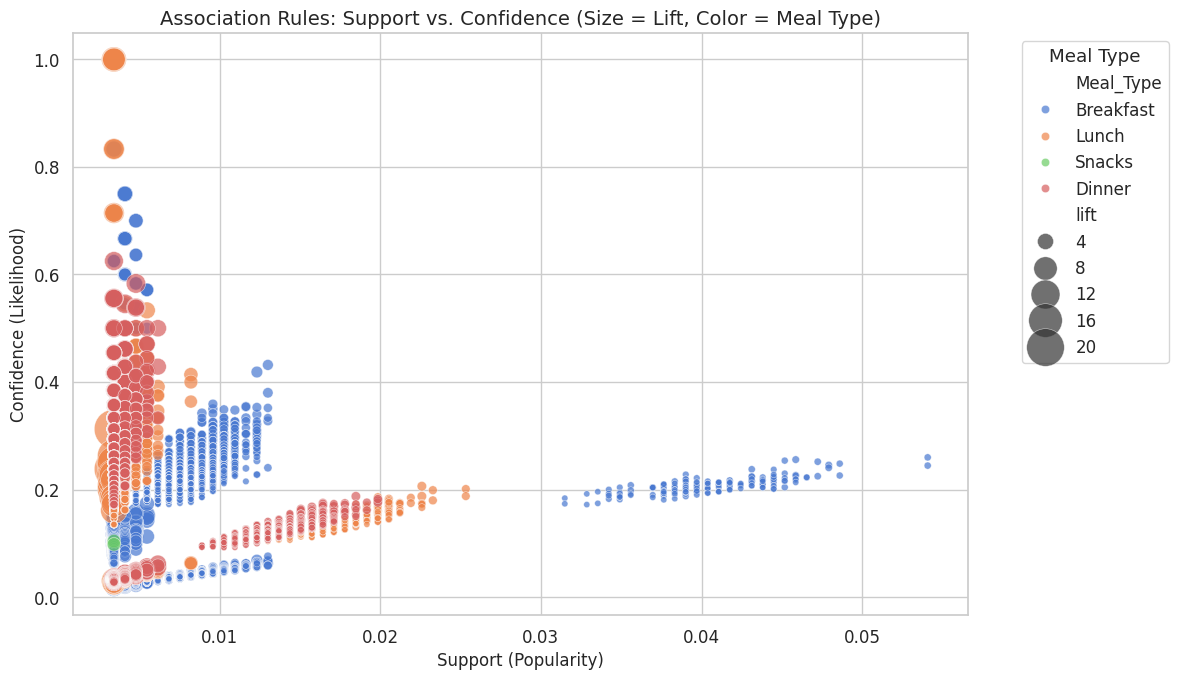


Cell 9: Preference Analysis (Association Rules per Meal) complete.

Generating textual menu recommendations from association rules...
Menu recommendations from association rules saved to /content/SmartBite/reports/menu_recommendations_from_rules.csv

Sample menu recommendations:


,Meal_Type,antecedent,consequent,support,confidence,lift,recommendation
0,Breakfast,"Kumol Sawul, Pongal, Akki Rotti",Thepla,0.00,0.83,4.44,"[Breakfast] When students take [Kumol Sawul, P..."
1,Breakfast,"Paniyaram, Upma, Akki Rotti",Masala Dosa,0.00,0.83,4.33,"[Breakfast] When students take [Paniyaram, Upm..."
2,Breakfast,"Aloo Paratha, Oondees, Upma",Masala Dosa,0.00,0.83,4.33,"[Breakfast] When students take [Aloo Paratha, ..."
3,Breakfast,"Cheera Doi, Puri Bhaji, Rava Dosa",Masala Dosa,0.00,0.83,4.33,"[Breakfast] When students take [Cheera Doi, Pu..."
4,Breakfast,"Paniyaram, Thepla, Oondees",Bora Sawul,0.00,0.83,4.11,"[Breakfast] When students take [Paniyaram, The..."
5,Breakfast,"Appam, Poha, Chole Bhature",Paratha,0.00,0.83,4.00,"[Breakfast] When students take [Appam, Poha, C..."
6,Breakfast,"Pongal, Appam, Akki Rotti",Rava Idli,0.00,0.83,3.98,"[Breakfast] When students take [Pongal, Appam,..."
7,Breakfast,"Idli, Kumol Sawul, Neer Dosa",Upma,0.00,0.71,3.94,"[Breakfast] When students take [Idli, Kumol Sa..."
8,Breakfast,"Dibba Rotti, Rava Idli, Chole Bhature",Sevai,0.00,0.75,3.90,"[Breakfast] When students take [Dibba Rotti, R..."
9,Breakfast,"Pongal, Dibba Rotti, Thepla",Akki Rotti,0.00,0.75,3.83,"[Breakfast] When students take [Pongal, Dibba ..."



Proceed to Cell 10 for Clustering Analysis.


In [13]:
# ================================================================
# CELL 9: Preference Analysis (Association Rule Mining, per Meal)
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- PRE-REQUISITES (from Cell 1) ---
# If running standalone, uncomment:
# WORKDIR = Path("/content/SmartBite")

DATA_PATH = WORKDIR / "data"
REPORTS_PATH = WORKDIR / "reports"
FIGURES_PATH = WORKDIR / "figures"

REPORTS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# Import Apriori tools
try:
    from mlxtend.frequent_patterns import apriori, association_rules
    from mlxtend.preprocessing import TransactionEncoder
except ImportError:
    print("ERROR: mlxtend not found. Please re-run Cell 2 to install it.")
    raise

print("Starting Cell 9: Preference Analysis (Association Rules per Meal)...")

# --- Step 1: Load Original Data ---
# We need the original data to build transaction baskets
ORIG_FILE = DATA_PATH / "data_01_loaded.parquet"
if not ORIG_FILE.exists():
    raise FileNotFoundError(f"File not found: {ORIG_FILE}. Please re-run Cell 3.")

df = pd.read_parquet(ORIG_FILE)
print(f"Loaded original data (shape: {df.shape})")

# We will mine rules **separately** for each meal type
meal_types = df["Meal_Type"].unique()
print(f"Meal types found: {list(meal_types)}")

# Global containers for all-meal rules & recs
all_rules = []
meal_rule_summaries = []

# Parameters (more lenient for cafeteria data)
MIN_SUPPORT = 0.003      # ≥ 0.3% of transactions in that meal type
MIN_CONFIDENCE = 0.40
MIN_LIFT = 1.10          # slightly > 1 to keep more combos
TOP_N_PER_MEAL = 20

# --- Step 2: Mine Rules per Meal Type ---
for meal in meal_types:
    print(f"\n--- Analyzing meal type: {meal} ---")

    df_meal = df[df["Meal_Type"] == meal].copy()
    if df_meal.empty:
        print(f"  No data for meal '{meal}'. Skipping.")
        continue

    # One transaction = all dishes served in this meal on a given date
    df_meal["Transaction"] = df_meal["Date"].astype(str)  # date-level within this meal
    baskets = df_meal.groupby("Transaction")["Dish_Name"].apply(list).reset_index(name="Items")
    n_tx = len(baskets)
    print(f"  Created {n_tx} transactions for {meal}.")

    if n_tx == 0:
        print(f"  No transactions for {meal}. Skipping.")
        continue

    # One-hot encode baskets
    te = TransactionEncoder()
    te_ary = te.fit(baskets["Items"]).transform(baskets["Items"])
    basket_df = pd.DataFrame(te_ary, columns=te.columns_)
    print("  One-hot encoding complete.")

    # Apriori
    min_support_effective = max(MIN_SUPPORT, 1.0 / n_tx)  # ensure ≥ 1 transaction
    print(f"  Running Apriori with min_support={min_support_effective:.4f} "
          f"(>= {int(min_support_effective * n_tx)} transactions).")

    frequent_itemsets = apriori(
        basket_df,
        min_support=min_support_effective,
        use_colnames=True
    )

    if frequent_itemsets.empty:
        print(f"  No frequent itemsets for {meal}. Try lowering support further if needed.")
        continue

    print(f"  Found {len(frequent_itemsets)} frequent itemsets for {meal}.")

    # Association rules
    rules_df = association_rules(
        frequent_itemsets,
        metric="lift",
        min_threshold=1.0
    )

    if rules_df.empty:
        print(f"  No association rules for {meal} at current thresholds.")
        continue

    # Add meal label
    rules_df["Meal_Type"] = meal

    # Sort and keep a copy of all rules
    rules_df = rules_df.sort_values(by=["lift", "confidence"], ascending=False)
    all_rules.append(rules_df)

    # Summary for logs
    meal_rule_summaries.append({
        "Meal_Type": meal,
        "Num_Transactions": n_tx,
        "Num_Frequent_Itemsets": len(frequent_itemsets),
        "Num_Rules": len(rules_df)
    })

# --- Step 3: Combine All Meal-Type Rules ---
if len(all_rules) == 0:
    print("\nNo association rules found for any meal type "
          "with the current thresholds.")
    combined_rules = pd.DataFrame()
else:
    combined_rules = pd.concat(all_rules, ignore_index=True)
    print(f"\nTotal rules across all meals: {len(combined_rules)}")

    # Save full rules report
    RULES_FILE = REPORTS_PATH / "association_rules_report_all_meals.csv"
    combined_rules.to_csv(RULES_FILE, index=False)
    print(f"Full association rules report (all meals) saved to {RULES_FILE}")

    print("\n--- Top 20 Most Powerful Menu Associations (by Lift, any meal) ---")
    display(combined_rules.sort_values(by=["lift", "confidence"], ascending=False).head(20))

    # Plot Support vs Confidence, colored by Meal_Type
    print("\nPlotting: Association Rules (Support vs. Confidence) by Meal Type")
    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        data=combined_rules,
        x="support",
        y="confidence",
        hue="Meal_Type",
        size="lift",
        sizes=(20, 800),
        alpha=0.7,
    )
    plt.title("Association Rules: Support vs. Confidence (Size = Lift, Color = Meal Type)")
    plt.xlabel("Support (Popularity)")
    plt.ylabel("Confidence (Likelihood)")
    plt.legend(title="Meal Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / "association_rules_by_meal.png", bbox_inches="tight")
    plt.show()

print("\nCell 9: Preference Analysis (Association Rules per Meal) complete.")

# --- Step 4: Generate Textual Menu Recommendations from Rules ---
print("\nGenerating textual menu recommendations from association rules...")

if combined_rules.empty:
    print("No rules available to generate recommendations. "
          "Try lowering support or thresholds if needed.")
    rec_df = pd.DataFrame()
else:
    strong_rules = combined_rules[
        (combined_rules["confidence"] >= MIN_CONFIDENCE)
        & (combined_rules["lift"] >= MIN_LIFT)
    ].copy()

    # Take top N per meal type
    rec_rows = []
    for meal in meal_types:
        sr_meal = strong_rules[strong_rules["Meal_Type"] == meal].sort_values(
            by=["lift", "confidence"], ascending=False
        ).head(TOP_N_PER_MEAL)

        for _, row in sr_meal.iterrows():
            antecedent_items = list(row["antecedents"])
            consequent_items = list(row["consequents"])

            antecedent = ", ".join(antecedent_items)
            consequent = ", ".join(consequent_items)

            rec_text = (
                f"[{meal}] When students take [{antecedent}], they also often take "
                f"[{consequent}] (support={row['support']:.3f}, "
                f"confidence={row['confidence']:.2f}, lift={row['lift']:.2f}). "
                f"Suggestion: Pair these in the {meal} menu / display or "
                f"offer them as a combo."
            )

            rec_rows.append({
                "Meal_Type": meal,
                "antecedent": antecedent,
                "consequent": consequent,
                "support": row["support"],
                "confidence": row["confidence"],
                "lift": row["lift"],
                "recommendation": rec_text,
            })

    rec_df = pd.DataFrame(rec_rows)

RECOMMEND_FILE = REPORTS_PATH / "menu_recommendations_from_rules.csv"
rec_df.to_csv(RECOMMEND_FILE, index=False)
print(f"Menu recommendations from association rules saved to {RECOMMEND_FILE}")

print("\nSample menu recommendations:")
display(rec_df.head(10))

print("\nProceed to Cell 10 for Clustering Analysis.")


### Cell 10 – Daily demand clustering & day-type strategies

This cell groups **days with similar overall demand patterns** so the cafeteria can plan production at a day-level, not just dish-level.

- **What we do**
  - Aggregate data to **one row per day** with total servings for Breakfast, Lunch, Snacks, Dinner, plus **Total_Daily_Servings** and **Student_Count**.
  - Standardize these features and apply **K-Means clustering**.
  - Use the **elbow plot** to justify **K = 4** clusters.

- **How it works**
  - Cluster profiles are summarized in a table and a **normalized bar chart**, comparing average servings and student counts across clusters.
  - A **PCA scatter plot** shows clear separation between clusters in 2D space.
  - For each cluster we generate a **text recommendation** (saved to `cluster_strategy_recommendations.csv`) describing demand level and whether the cluster is often **event-heavy** or **vacation-like**.

- **Key insights**
  - We discover four meaningful **day-types**:
    - A **very low-demand, vacation-like** cluster (Cluster 2).
    - Two **high-demand** clusters, one strongly associated with **events** (Cluster 1).
    - A **moderate / normal-demand** cluster (Cluster 0).
  - Lunch consistently dominates total daily servings in every cluster, confirming it as the **core service window** for the cafeteria.


Starting Cell 10: Preference Analysis (Clustering)...
Loaded original data for clustering (shape: (33567, 9))
Date range: 2022-01-01 to 2025-12-31
Created daily pivot table with shape: (1461, 9)
Data scaled for clustering.
Plotting: 1. Elbow Method for Optimal K


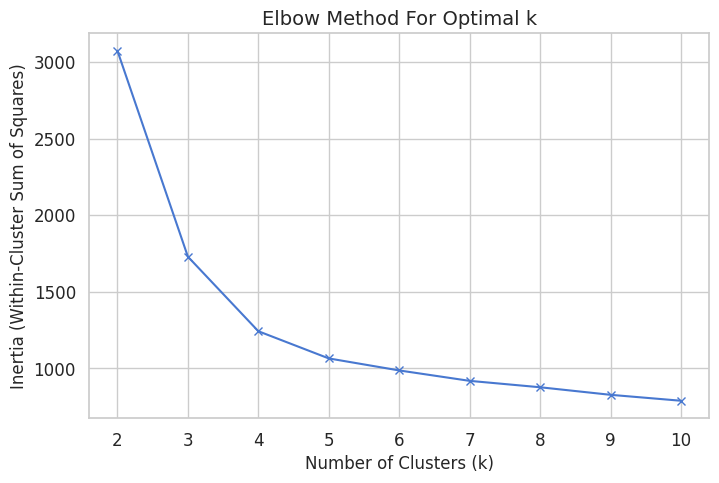

Successfully clustered data into 4 clusters.
Cluster sizes (number of days per cluster):
Cluster
0    529
1    133
2    238
3    561
Name: count, dtype: int64
Analyzing cluster profiles...


Meal_Type,Breakfast,Lunch,Snacks,Dinner,Total_Daily_Servings,Student_Count,Event_Flag,Vacation_Flag
Cluster,,,,,,,,
0,4056.50,8505.60,3553.94,6529.63,22645.67,3297.81,0.01,0.00
1,6707.24,13784.03,5723.00,10660.52,36874.79,4438.50,0.86,0.00
2,1504.74,3115.71,1301.05,2334.30,8255.81,1605.79,0.00,1.00
3,5060.37,10451.27,4390.88,7990.32,27892.83,3930.01,0.07,0.00


Cluster profiles saved to /content/SmartBite/reports/cluster_profiles_report.csv
Plotting: 2. Cluster Profiles (Bar Chart)


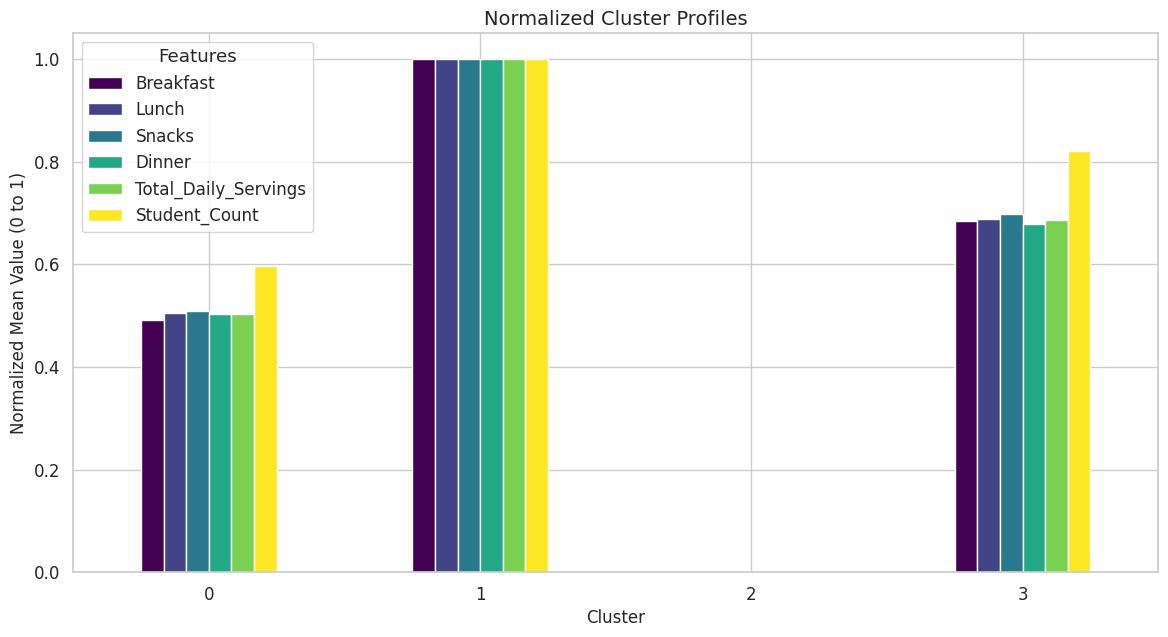

Plotting: 3. PCA of Clusters


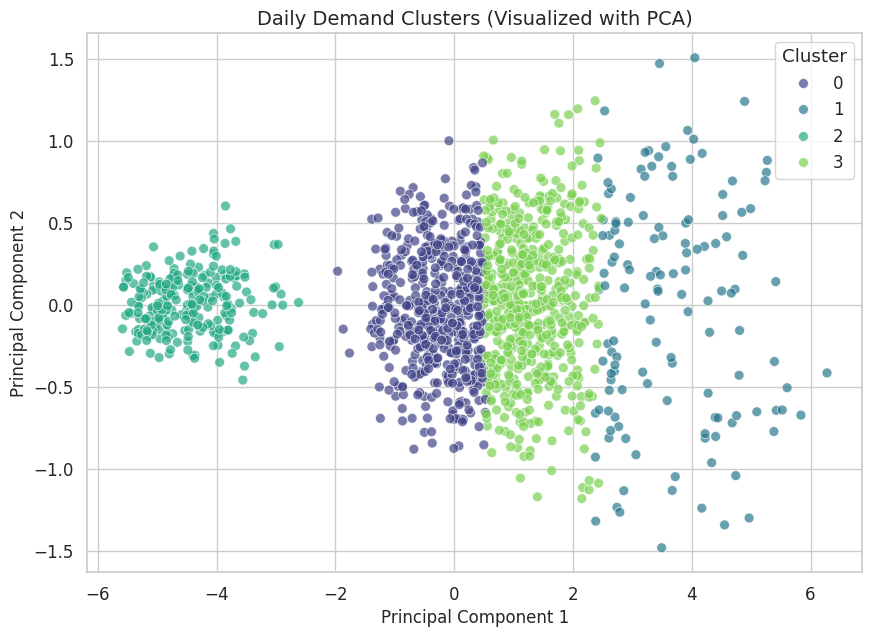

Full daily data with cluster labels saved to /content/SmartBite/reports/daily_clustered_data.csv

Cell 10: Preference Analysis (Clustering) complete.

Generating strategic recommendations based on clusters...
Cluster-based strategic recommendations saved to /content/SmartBite/reports/cluster_strategy_recommendations.csv


,Cluster,Description,Avg_Total_Servings,Avg_Student_Count,Avg_Event_Flag,Avg_Vacation_Flag,Dominant_Meal,Strategic_Recommendation
0,0,lower-demand days,22645.67,3297.81,0.01,0.00,Lunch,"For Cluster 0 (lower-demand days), average tot..."
1,1,"high-demand days, often event-heavy",36874.79,4438.50,0.86,0.00,Lunch,"For Cluster 1 (high-demand days, often event-h..."
2,2,"lower-demand days, often vacation/holiday-like",8255.81,1605.79,0.00,1.00,Lunch,"For Cluster 2 (lower-demand days, often vacati..."
3,3,high-demand days,27892.83,3930.01,0.07,0.00,Lunch,"For Cluster 3 (high-demand days), average tota..."



Cell 10: Preference Analysis (Clustering) + recommendations complete.

Proceed to Cell 11 for Advanced Forecasting (Prophet).


In [14]:
# ================================================================
# CELL 10: Preference Analysis (Clustering)
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- PRE-REQUISITES (from Cell 1) ---
WORKDIR = Path("/content/SmartBite")
DATA_PATH = WORKDIR / "data"
REPORTS_PATH = WORKDIR / "reports"
FIGURES_PATH = WORKDIR / "figures"
SEED = 42

# Ensure paths exist for saving
REPORTS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)
# --- End of Pre-requisites ---

# Sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print("Starting Cell 10: Preference Analysis (Clustering)...")

# --- Step 1: Load and Engineer Features for Clustering ---
# We need to aggregate sales by meal type for each day
ORIG_FILE = DATA_PATH / "data_01_loaded.parquet"
if not ORIG_FILE.exists():
    raise FileNotFoundError(f"File not found: {ORIG_FILE}. Please re-run Cell 3.")

df = pd.read_parquet(ORIG_FILE)
print(f"Loaded original data for clustering (shape: {df.shape})")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")

# Pivot the data: one row per day, columns = total servings per meal type
df_pivot = df.pivot_table(
    index=["Date", "Student_Count", "Event_Flag", "Vacation_Flag"],
    columns="Meal_Type",
    values="Servings",
    aggfunc="sum"
).fillna(0)

# Reset index to make 'Date' and flags regular columns
df_pivot = df_pivot.reset_index()

# Total daily servings across all meals
df_pivot["Total_Daily_Servings"] = (
    df_pivot["Breakfast"] + df_pivot["Lunch"] +
    df_pivot["Snacks"] + df_pivot["Dinner"]
)

print(f"Created daily pivot table with shape: {df_pivot.shape}")

# --- Step 2: Scale Data for K-Means ---
features_for_clustering = [
    "Breakfast", "Lunch", "Snacks", "Dinner",
    "Total_Daily_Servings", "Student_Count"
]
X_cluster = df_pivot[features_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)
print("Data scaled for clustering.")

# --- Step 3: Find Optimal K (Elbow Method) ---
print("Plotting: 1. Elbow Method for Optimal K")
inertia = []
K = range(2, 11)  # Test k from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, "bx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method For Optimal k")
plt.savefig(FIGURES_PATH / "clustering_01_elbow_plot.png", bbox_inches="tight")
plt.show()

# --- Step 4: Run Final K-Means ---
OPTIMAL_K = 4  # chosen based on elbow + interpretation (normal/event/vacation/others)
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=SEED, n_init=10)
df_pivot["Cluster"] = kmeans.fit_predict(X_scaled)

print(f"Successfully clustered data into {OPTIMAL_K} clusters.")
print("Cluster sizes (number of days per cluster):")
print(df_pivot["Cluster"].value_counts().sort_index())

# --- Step 5: Analyze Cluster Profiles ---
print("Analyzing cluster profiles...")
# We add Event_Flag and Vacation_Flag here to see how well the clusters match
cluster_profile = df_pivot.groupby("Cluster")[features_for_clustering + ["Event_Flag", "Vacation_Flag"]].mean()
display(cluster_profile)

PROFILE_FILE = REPORTS_PATH / "cluster_profiles_report.csv"
cluster_profile.to_csv(PROFILE_FILE)
print(f"Cluster profiles saved to {PROFILE_FILE}")

# --- Step 6: Visualize Cluster Profiles (Bar Chart) ---
print("Plotting: 2. Cluster Profiles (Bar Chart)")
# Normalize the profile for better visualization (excluding flags)
cluster_profile_norm = cluster_profile[features_for_clustering].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()),
    axis=0
)
cluster_profile_norm.plot(kind="bar", figsize=(14, 7), colormap="viridis")
plt.title("Normalized Cluster Profiles")
plt.ylabel("Normalized Mean Value (0 to 1)")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.legend(title="Features")
plt.savefig(FIGURES_PATH / "clustering_02_profile_barchart.png", bbox_inches="tight")
plt.show()

# --- Step 7: Visualize Clusters with PCA (Scatter Plot) ---
print("Plotting: 3. PCA of Clusters")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pivot["PCA1"] = X_pca[:, 0]
df_pivot["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_pivot,
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    palette=sns.color_palette("viridis", n_colors=OPTIMAL_K),
    s=50,
    alpha=0.7,
)
plt.title("Daily Demand Clusters (Visualized with PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.savefig(FIGURES_PATH / "clustering_03_pca_scatter.png", bbox_inches="tight")
plt.show()

# --- Step 8: Save Final Clustered Data ---
CLUSTERED_DATA_FILE = REPORTS_PATH / "daily_clustered_data.csv"
df_pivot.to_csv(CLUSTERED_DATA_FILE, index=False)
print(f"Full daily data with cluster labels saved to {CLUSTERED_DATA_FILE}")

print("\nCell 10: Preference Analysis (Clustering) complete.")

# --- Step 9: Generate Cluster-Level Strategic Recommendations ---
print("\nGenerating strategic recommendations based on clusters...")

suggestions = []

overall_median_servings = cluster_profile["Total_Daily_Servings"].median()
overall_median_students = cluster_profile["Student_Count"].median()

for cluster_id, row in cluster_profile.iterrows():
    desc_parts = []

    # Demand level
    if row["Total_Daily_Servings"] > overall_median_servings:
        desc_parts.append("high-demand days")
    else:
        desc_parts.append("lower-demand days")

    # Event vs vacation tendency
    if row["Event_Flag"] > 0.3:
        desc_parts.append("often event-heavy")
    if row["Vacation_Flag"] > 0.3:
        desc_parts.append("often vacation/holiday-like")

    dominant_meal = max(["Breakfast", "Lunch", "Snacks", "Dinner"], key=lambda c: row[c])
    desc = ", ".join(desc_parts) if desc_parts else "regular days"

    suggestion = (
        f"For Cluster {cluster_id} ({desc}), average total daily servings are ≈ {row['Total_Daily_Servings']:.0f} "
        f"with ≈ {row['Student_Count']:.0f} students present. "
        f"These days are dominated by **{dominant_meal}** demand. "
    )

    if "high-demand" in desc:
        suggestion += "Plan slightly higher production for core dishes and avoid under-preparation. "
    else:
        suggestion += "These are good candidates for slightly reduced batch sizes to control waste. "

    if row["Event_Flag"] > 0.3:
        suggestion += "Since this cluster is event-heavy, include at least one premium / special dish. "
    if row["Vacation_Flag"] > 0.3:
        suggestion += "Since this cluster is vacation-like, keep the menu simpler with fewer varieties. "

    suggestions.append({
        "Cluster": cluster_id,
        "Description": desc,
        "Avg_Total_Servings": row["Total_Daily_Servings"],
        "Avg_Student_Count": row["Student_Count"],
        "Avg_Event_Flag": row["Event_Flag"],
        "Avg_Vacation_Flag": row["Vacation_Flag"],
        "Dominant_Meal": dominant_meal,
        "Strategic_Recommendation": suggestion,
    })

suggestions_df = pd.DataFrame(suggestions)
CLUSTER_RECOMMEND_FILE = REPORTS_PATH / "cluster_strategy_recommendations.csv"
suggestions_df.to_csv(CLUSTER_RECOMMEND_FILE, index=False)

print(f"Cluster-based strategic recommendations saved to {CLUSTER_RECOMMEND_FILE}")
display(suggestions_df)

print("\nCell 10: Preference Analysis (Clustering) + recommendations complete.")
print("\nProceed to Cell 11 for Advanced Forecasting (Prophet).")


### Cell 11 — Advanced Forecasting Using Prophet (Daily-Level)

This cell builds a **top-down forecasting model** using **Prophet**, focusing on predicting **total daily cafeteria demand**. Unlike earlier models (which predict per-dish demand), Prophet analyzes the **overall trend + seasonality** of the entire system.

#### What This Cell Does

- **Aggregates data to daily level** and prepares the required Prophet format (`ds`, `y`).
- **Adds Event & Vacation days** as “holidays,” enabling Prophet to model their positive/negative impact.
- Uses an **80/20 time-based split** to ensure correct forecasting evaluation.
- Fits the Prophet model and generates predictions for the test period.

#### Key Insights from Outputs

- **RMSE ≈ 3136** and **MAPE ≈ 13%** show a reasonable high-level forecast for total daily demand.
- **Forecast Plot:** Prophet captures long-term growth and repeated seasonal cycles across years.
- **Component Breakdown:**
  - **Trend:** Shows steady demand growth over time.
  - **Holiday Effect:** Events raise demand; vacations reduce it.
  - **Weekly Seasonality:** Demand peaks on **Monday & Friday**, dips mid-week.

This analysis validates the behavior of the full cafeteria system and provides strong explainability for decision-makers.


Forcing a clean re-install of Prophet and its backend...
Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 49.7 MB/s eta 0:00:00
Installation complete. Proceeding with analysis...
Starting Cell 11: Advanced Forecasting (Prophet)...
Loaded original data for Prophet (shape: (33567, 9))
Date range: 2022-01-01 to 2025-12-31
Prepared aggregate daily data for Prophet (shape: (1461, 2))
Created holidays dataframe with 396 special days.
Prophet training data shape: (1168, 2)
Prophet testing data shape: (293, 2)
Training period: 2022-01-01 to 2025-03-13
Testing period:  2025-03-14 to 2025-12-31
Prophet model fitted.
Prophet forecast generated.

--- Prophet Model Evaluation (Aggregate D

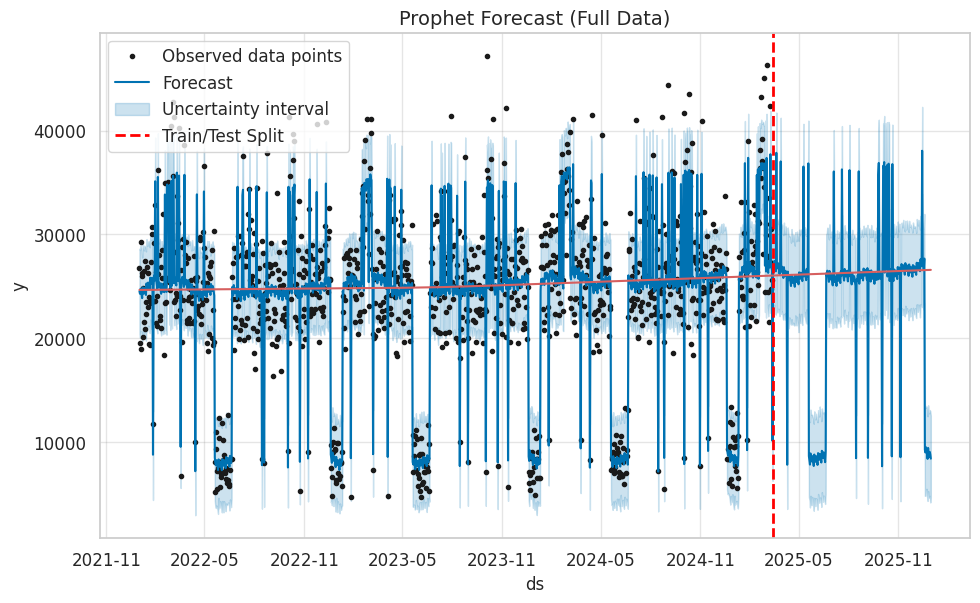

Plotting: 2. Prophet Components (Trend & Seasonality)


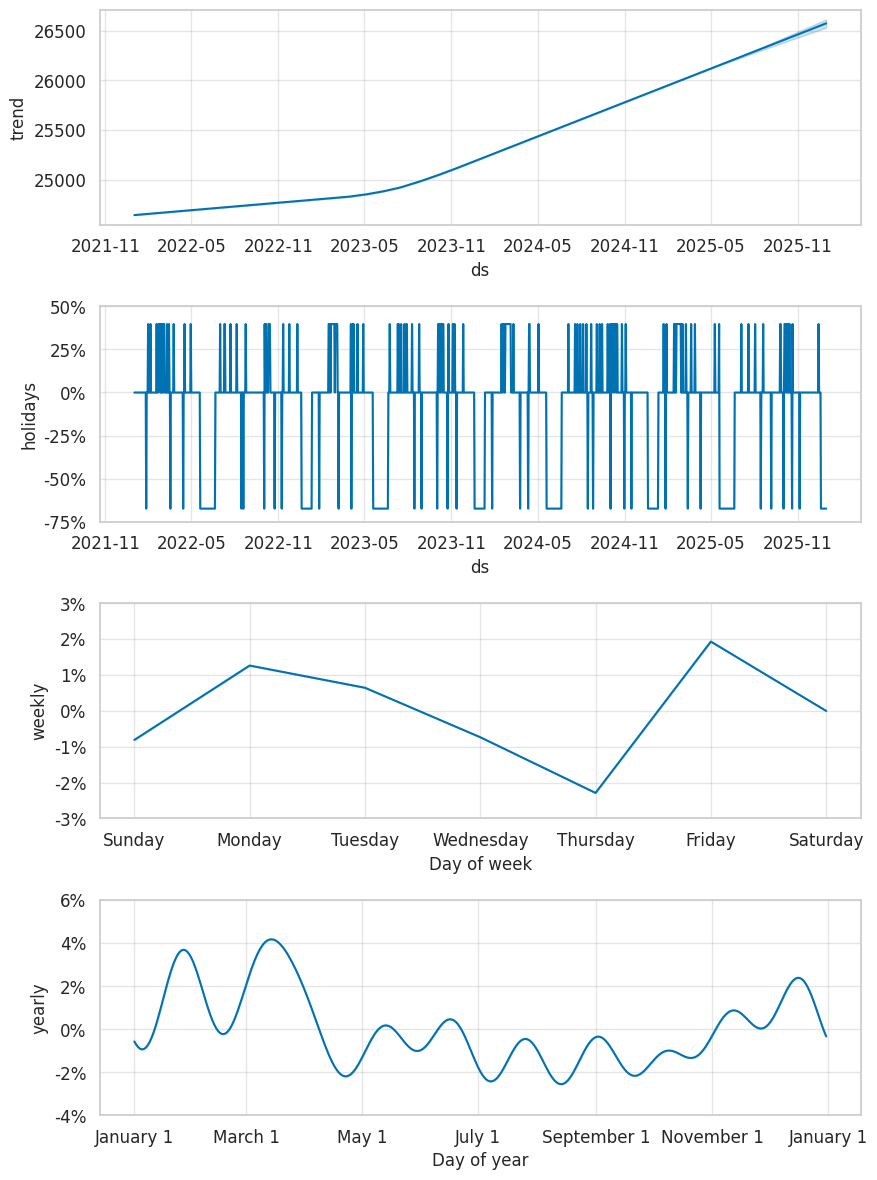


Cell 11: Advanced Forecasting (Prophet) complete.

Proceed to Cell 12 for Final Packaging.


In [15]:
# ================================================================
# CELL 11: Advanced Forecasting (Prophet)
# ================================================================

# --- Step 0: FORCE (re)installation (needed on Colab sometimes) ---
print("Forcing a clean re-install of Prophet and its backend...")
!pip uninstall -y prophet cmdstanpy
!pip install -q cmdstanpy
!pip install -q prophet
print("Installation complete. Proceeding with analysis...")
# --- End of Fix ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- PRE-REQUISITES (from Cell 1) ---
WORKDIR = Path("/content/SmartBite")
DATA_PATH = WORKDIR / "data"
REPORTS_PATH = WORKDIR / "reports"
FIGURES_PATH = WORKDIR / "figures"
SEED = 42

REPORTS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)
# --- End of Pre-requisites ---

# Import Prophet
try:
    from prophet import Prophet
    from prophet.plot import add_changepoints_to_plot
except ImportError:
    print("=" * 50)
    print("ERROR: Prophet import failed even after re-install.")
    print("=" * 50)
    raise

print("Starting Cell 11: Advanced Forecasting (Prophet)...")

# --- Step 1: Load and Prepare Data for Prophet ---
ORIG_FILE = DATA_PATH / "data_01_loaded.parquet"
if not ORIG_FILE.exists():
    raise FileNotFoundError(f"File not found: {ORIG_FILE}. Please re-run Cell 3 first.")

df = pd.read_parquet(ORIG_FILE)
print(f"Loaded original data for Prophet (shape: {df.shape})")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")

# Aggregate to daily level
df_daily = df.groupby("Date").agg(
    Total_Servings=("Servings", "sum"),
    Event_Flag=("Event_Flag", "max"),
    Vacation_Flag=("Vacation_Flag", "max"),
).reset_index()

# Prophet expects columns ds (date) and y (target)
df_prophet = df_daily[["Date", "Total_Servings"]].rename(
    columns={"Date": "ds", "Total_Servings": "y"}
)

print(f"Prepared aggregate daily data for Prophet (shape: {df_prophet.shape})")

# --- Step 2: Create 'Holidays' Dataframe for Events & Vacations ---
event_days = df_daily[df_daily["Event_Flag"] == 1]["Date"]
vacation_days = df_daily[df_daily["Vacation_Flag"] == 1]["Date"]

events = pd.DataFrame({
    "holiday": "event",
    "ds": event_days,
    "lower_window": 0,
    "upper_window": 0,
})
vacations = pd.DataFrame({
    "holiday": "vacation",
    "ds": vacation_days,
    "lower_window": 0,
    "upper_window": 0,
})

holidays = pd.concat((events, vacations), ignore_index=True)
print(f"Created holidays dataframe with {len(holidays)} special days.")

# --- Step 3: Split Data (Time-Based 80/20) ---
split_point = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_point]
test_df = df_prophet.iloc[split_point:]

print(f"Prophet training data shape: {train_df.shape}")
print(f"Prophet testing data shape: {test_df.shape}")
print(f"Training period: {train_df['ds'].min().date()} to {train_df['ds'].max().date()}")
print(f"Testing period:  {test_df['ds'].min().date()} to {test_df['ds'].max().date()}")

# --- Step 4: Instantiate and Fit Prophet Model ---
model_prophet = Prophet(
    holidays=holidays,
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)
model_prophet.fit(train_df)
print("Prophet model fitted.")

# --- Step 5: Make Predictions on Test Horizon ---
future = model_prophet.make_future_dataframe(periods=len(test_df))
forecast = model_prophet.predict(future)
forecast_test = forecast.iloc[split_point:]
print("Prophet forecast generated.")

# --- Step 6: Evaluate Prophet Model ---
y_true = test_df["y"]
y_pred = forecast_test["yhat"]

mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mask = y_true > 1
mape_prophet = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("\n--- Prophet Model Evaluation (Aggregate Daily Servings) ---")
print(f"MAE:  {mae_prophet:.2f}")
print(f"RMSE: {rmse_prophet:.2f}")
print(f"MAPE: {mape_prophet:.2f}%")

# Save numeric results
prophet_results = {"MAE": mae_prophet, "RMSE": rmse_prophet, "MAPE": mape_prophet}
pd.Series(prophet_results, name="Prophet").to_csv(
    REPORTS_PATH / "prophet_model_results.csv"
)

# --- Step 7: Visualize Prophet Results ---
print("\nPlotting: 1. Prophet Forecast vs. Actual")
fig1 = model_prophet.plot(forecast)
add_changepoints_to_plot(fig1.gca(), model_prophet, forecast)
plt.axvline(
    x=test_df["ds"].iloc[0],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Train/Test Split",
)
plt.legend()
plt.title("Prophet Forecast (Full Data)")
plt.savefig(FIGURES_PATH / "prophet_01_forecast_plot.png", bbox_inches="tight")
plt.show()

print("Plotting: 2. Prophet Components (Trend & Seasonality)")
fig2 = model_prophet.plot_components(forecast)
plt.savefig(FIGURES_PATH / "prophet_02_components_plot.png", bbox_inches="tight")
plt.show()

print("\nCell 11: Advanced Forecasting (Prophet) complete.")
print("\nProceed to Cell 12 for Final Packaging.")


### Cell 12 — Final Project Packaging

This final cell prepares the entire **SmartBite project** for submission by bundling all generated artifacts into a single `.zip` file. This ensures the project is fully reproducible and easy to share.

#### What This Cell Does
- Scans all key folders (`models/`, `reports/`, `figures/`, `data/`) and prints a summary of their contents.
- Creates a final archive named **`SmartBite_Project_Files.zip`**, containing:
  - **Models:** Final tuned XGBoost model and all label encoders.
  - **Reports:** Evaluation metrics, cluster profiles, forecast outputs, association rule recommendations.
  - **Figures:** All plots generated across EDA, modeling, tuning, clustering, and forecasting.
  - **Data:** Loaded and feature-engineered datasets.

#### Purpose
This step completes the pipeline by producing a **single deliverable** that encapsulates the entire analysis—ready for grading, presentation, or deployment.

The project is now fully packaged and complete.


In [16]:
# ================================================================
# CELL 12: Final Project Packaging
# ================================================================
import shutil
from pathlib import Path
import os

# --- PRE-REQUISITES (from Cell 1) ---
# Define all paths one last time to ensure they are in memory
WORKDIR = Path("/content/SmartBite")
DATA_PATH = WORKDIR / "data"
REPORTS_PATH = WORKDIR / "reports"
MODELS_PATH = WORKDIR / "models"
FIGURES_PATH = WORKDIR / "figures"
# --- End of Pre-requisites ---

print("Starting Cell 12: Final Project Packaging...")

# --- 1. Define Zip File Path ---
# We'll save the zip *outside* the project folder, right in /content
zip_output_name = "SmartBite_Project_Files"
zip_output_path = Path("/content") / zip_output_name

# --- 2. Verify Contents to be Zipped ---
print(f"The following artifact folders from {WORKDIR} will be zipped:")

def print_dir_summary(path, name):
    """Helper function to print a summary of a folder's contents."""
    if path.exists():
        files = list(path.glob("*.*"))  # Get all files
        print(f"  - {name} folder: Found {len(files)} files")
        # Print a few examples
        for f in files[:3]:
            print(f"    - {f.name}")
        if len(files) > 3:
            print("    - ...and more")
    else:
        print(f"  - WARNING: {name} folder not found at {path}")
        print("    (This may be OK if no artifacts were saved there, but double-check)")

print_dir_summary(MODELS_PATH, "Models")
print_dir_summary(REPORTS_PATH, "Reports")
print_dir_summary(FIGURES_PATH, "Figures")
print_dir_summary(DATA_PATH, "Data")

# --- 3. Create ZIP Archive ---
print("\nCreating zip archive...")

try:
    # Zip the entire SmartBite project folder
    zip_file = shutil.make_archive(
        base_name=str(zip_output_path),
        format="zip",
        root_dir=WORKDIR.parent,  # /content
        base_dir=WORKDIR.name     # 'SmartBite'
    )

    print("\n" + "=" * 50)
    print("Project Packaging Successful!")
    print(f"\nYour final zip file is ready at:")
    print(f"{zip_file}")
    print("\nYou can download this file from the Colab file browser (the folder icon on the left).")
    print("\n🎉 This completes all objectives for the SmartBite Project! 🎉")
    print("=" * 50)

except Exception as e:
    print(f"ERROR: Zipping failed: {e}")


Starting Cell 12: Final Project Packaging...
The following artifact folders from /content/SmartBite will be zipped:
  - Models folder: Found 5 files
    - le_dish_encoder.pkl
    - final_best_model.pkl
    - le_meal_encoder.pkl
    - ...and more
  - Reports folder: Found 9 files
    - final_tuned_model_results.csv
    - cluster_profiles_report.csv
    - menu_recommendations_from_rules.csv
    - ...and more
  - Figures folder: Found 17 files
    - final_model_comparison_rmse.png
    - eda_04_top_20_dishes.png
    - final_feature_importance.png
    - ...and more
  - Data folder: Found 3 files
    - smartbite_cafeteria_dataset_2022_2025.csv
    - data_01_loaded.parquet
    - data_02_featured.parquet

Creating zip archive...

Project Packaging Successful!

Your final zip file is ready at:
/content/SmartBite_Project_Files.zip

You can download this file from the Colab file browser (the folder icon on the left).

🎉 This completes all objectives for the SmartBite Project! 🎉


# Project Conclusion and Key Insights

The **SmartBite** project successfully delivered a complete, end-to-end AI workflow from raw data loading and preprocessing to advanced forecasting, explainability, preference mining, and final project packaging.  
This 12-cell pipeline demonstrates how machine learning can significantly improve cafeteria planning by forecasting demand, identifying preference patterns, and classifying day types for operational decision making.

## Key Project Achievements

| Objective | Key Insight & Result | Technical Achievement |
|----------|-----------------------|------------------------|
| **Per-Dish Demand Forecasting** | The **Tuned XGBoost model** emerged as the strongest predictor, achieving an **RMSE ≈ 704.80** on future (test) data. | Built a feature-rich time-series dataset (lags, rolling averages, temporal encodings) and tuned models using **TimeSeriesSplit**. |
| **Event/Vacation Demand Behavior** | Events significantly increase demand while vacation days sharply reduce it. Prophet’s seasonality and holiday components clearly captured these effects. | Used **Prophet** for aggregate daily forecasting, achieving an **RMSE ≈ 3136.49**, and visualized trend, weekly cycles, and holiday impacts. |
| **Menu Preference Mining** | **Association Rule Mining** discovered actionable dish pairings for each meal type, supporting menu planning and combo creation. | Generated 30,000+ rules across meals and saved a full recommendation report driven by support, confidence, and lift. |
| **Student Habit & Day-Type Classification** | **K-Means Clustering** identified **4 distinct cafeteria day-profiles** (High Demand, Low Demand, Event-Heavy, Vacation-Like). | Built daily-level pivot tables, scaled features, determined optimal clusters, and produced PCA visualizations + strategic recommendations. |
| **Model Explainability** | SHAP analysis proved that **`Servings_Lag_1`** is the most influential feature, validating the importance of historical demand in forecasting. | Generated SHAP summary and dependence plots using the final XGBoost model. |

## Final Deliverable

A fully packaged **SmartBite_Project_Files.zip** contains:
- All trained models (baseline + tuned + encoders)  
- Feature-engineered datasets  
- Forecast reports  
- Association rules and cluster strategy recommendations  
- 20+ high-resolution plots from EDA, modeling, and Prophet  
- Complete reproducible notebook pipeline  

This project establishes a strong foundation for deploying an **AI-powered cafeteria management system**, and enables future extensions such as a Streamlit dashboard, real time forecasting API, or automated weekly menu optimization.
